# Reinforcement learning in electricity trading

In this notebook, we develop and train a Q-learning agent which learns when to trade electricity with a smart grid. We begin by importing the necessary libraries.

In [1]:
import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np
import time
import matplotlib.pyplot as plt
import time
import random
import pandas as pd
from random import randrange
import seaborn as sb

Next, we import the train and validation datasets. We preprocess the data and briefly overview it, to get a first impression. 

In [2]:
def add_features(df):
    df['month'] = df['PRICES'].dt.month - 1
    df['day'] = df['PRICES'].dt.day - 1
    df['year'] = df['PRICES'].dt.year
    df['day_of_week'] = df['PRICES'].dt.dayofweek
    df['day_of_week'] = df['day_of_week'].astype(int)
    df = df.drop(columns=["PRICES"])
    return df

train = pd.read_excel("train.xlsx", parse_dates=['PRICES'])
val = pd.read_excel("validate.xlsx", parse_dates=['PRICES'])
train = add_features(train)
val = add_features(val)


# Checking for NULL, NA values, and duplicates
print("Train NULL values:", train.isnull().sum().sum())     # no NULL values
print("Train NA values:", train.isna().sum().sum())         # no NA values
print("Train duplicates:", train.duplicated().sum())        # no duplicates

print("Validation NULL values:", val.isnull().sum().sum())  # no NULL values
print("Validation NA values:", val.isna().sum().sum())      # no NA values
print("Validation duplicates:", val.duplicated().sum())     # no duplicates

#getting a first impression of the data
print(train.head())




Train NULL values: 0
Train NA values: 0
Train duplicates: 0
Validation NULL values: 0
Validation NA values: 0
Validation duplicates: 0
   Hour 01  Hour 02  Hour 03  Hour 04  Hour 05  Hour 06  Hour 07  Hour 08  \
0    24.31    24.31    21.71     8.42     0.01     0.01     0.02     0.01   
1    16.01    11.00     9.01     7.50     9.00     7.45    16.50    28.01   
2    28.00    24.50    24.15    18.99    15.50    23.11    29.01    39.73   
3    31.01    28.69    27.00    24.20    12.02    27.00    28.00    34.85   
4    22.00    19.50    17.55    15.91    11.40    22.65    27.30    34.00   

   Hour 09  Hour 10  ...  Hour 19  Hour 20  Hour 21  Hour 22  Hour 23  \
0     0.01     6.31  ...    37.99    33.11    37.99    33.00    36.48   
1    29.96    39.60  ...    59.69    50.09    50.00    36.22    31.09   
2    43.81    49.09  ...    60.99    55.51    51.77    34.51    39.31   
3    41.31    42.03  ...    58.99    53.50    44.01    35.00    34.46   
4    40.01    45.00  ...    53.00    

# Exploratory Data Analysis

This code calculates daily average electricity prices from hourly data and stores them in a new column. It then visualizes these averages over time using a line plot. Boxplots compare the distribution of daily prices by year and by weekday to reveal seasonal and weekly patterns. A correlation heatmap highlights relationships between selected features to avoid multicollinearity. Finally, a histogram shows the distribution of daily prices specifically for the year 2007.

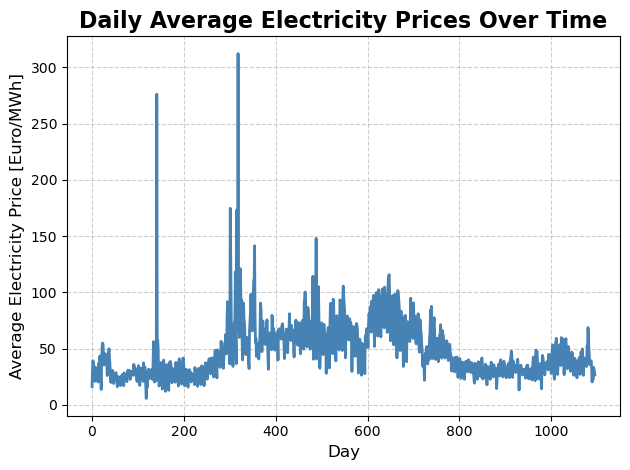

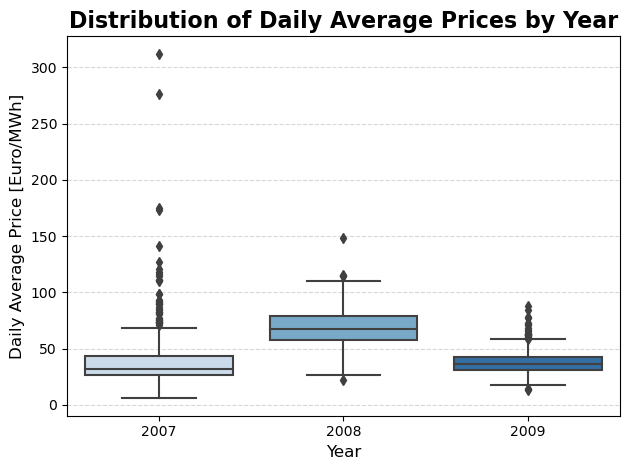

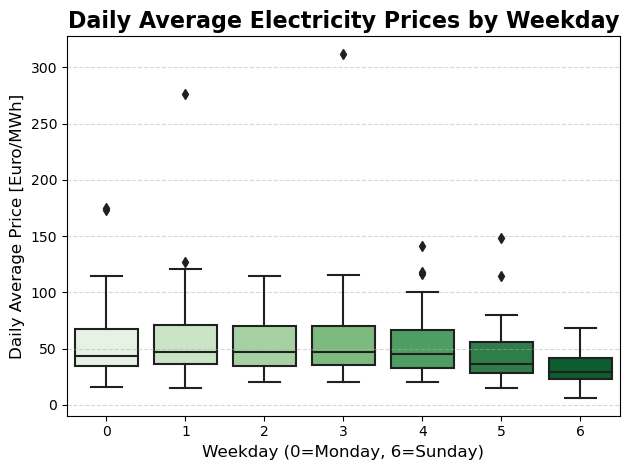

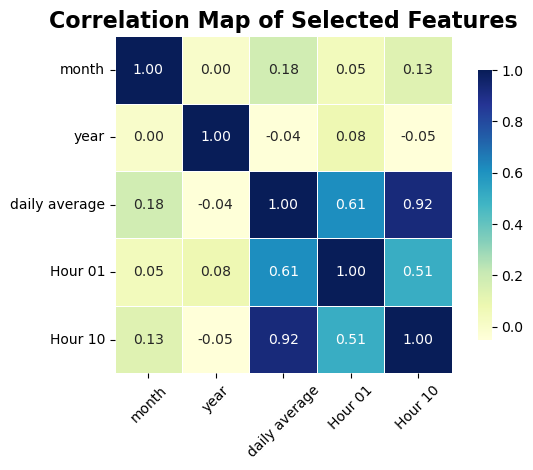

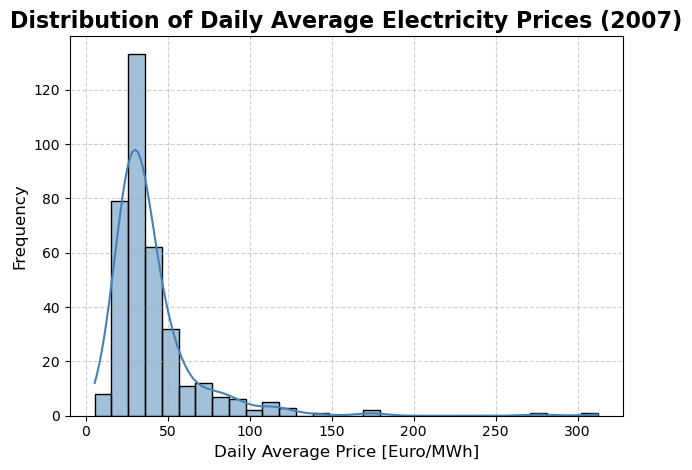

In [3]:
train['day of week']=train.day_of_week

no_days=train.shape[0]
daily_averages=np.zeros(no_days)
for i in range(no_days):
    daily_averages[i]=np.mean(train.iloc[i,1:25])
    
#line plot of daily averages
train['daily average'] = daily_averages

plt.figure()
plt.plot(train['daily average'], color='steelblue', linewidth=2)
plt.title('Daily Average Electricity Prices Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Day', fontsize=12)
plt.ylabel('Average Electricity Price [Euro/MWh]', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#boxplot of daily average price by year
plt.figure()
sb.boxplot(x='year', y='daily average', data=train, palette='Blues')
plt.title('Distribution of Daily Average Prices by Year', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Daily Average Price [Euro/MWh]', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#boxplot of daily average price by weekday
plt.figure()
sb.boxplot(x='day_of_week', y='daily average', data=train, palette='Greens')
plt.title('Daily Average Electricity Prices by Weekday', fontsize=16, fontweight='bold')
plt.xlabel('Weekday (0=Monday, 6=Sunday)', fontsize=12)
plt.ylabel('Daily Average Price [Euro/MWh]', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# a correlation heat map betwen various data features - we don't want to include fatures with high correlation 
plt.figure()
corr = train[['month', 'year', 'daily average', 'Hour 01', 'Hour 10']].corr()
sb.heatmap(corr, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})
plt.title('Correlation Map of Selected Features', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# histogram of Daily Average Prices (2007 only) 
plt.figure()
sb.histplot(train[train["year"] == 2007]['daily average'], kde=True, color='steelblue', bins=30)
plt.title('Distribution of Daily Average Electricity Prices (2007)', fontsize=16, fontweight='bold')
plt.xlabel('Daily Average Price [Euro/MWh]', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Price Bins

We bin the prices according to the sample quantiles, so the probability of a randomly sampled price being in each bin is equal across the bins. 

In [4]:
quants = np.zeros(11)
alphas = np.array(np.linspace(0,1,11))
for q in range(11):
    quants[q] = np.quantile(np.ravel(train.iloc[:,0:24].values), alphas[q] )
    

price_bins = quants
sums=train.iloc[:,0].value_counts(bins=price_bins)
for i in range(1,24):
    sums= sums+ train.iloc[:,i].value_counts(bins=price_bins)
print(sums)

(0.009000000000000001, 19.5]    2635
(19.5, 26.91]                   2631
(26.91, 32.16]                  2627
(32.16, 37.12]                  2631
(37.12, 43.0]                   2644
(43.0, 49.99]                   2616
(49.99, 59.941]                 2629
(59.941, 71.632]                2630
(71.632, 88.01]                 2631
(88.01, 2500.0]                 2630
dtype: int64


## Action Space

We define the action space to be the discrete space [-25, -12.5, 0, 12.5, 25], where each point represents the amount of electricity that is traded with the samrt grid. 

In [5]:
class CustomDiscreteActionSpace(spaces.Discrete):
    def __init__(self, start=-25, end=25, step=12.5):
        num_actions = int((end - start) / step) + 1
        super(CustomDiscreteActionSpace, self).__init__(num_actions)
        self.start = start
        self.step_size = step
        self.end = end
    def map_to_action(self, action_index):
        return self.start + action_index * self.step_size

custom_action_space = CustomDiscreteActionSpace()

## Define Environment

To model the constraints mentioned previously, an environment is constructed using the Gymnasium library from OpenAI.
While training the agent receives a state representation of the environment. This state representation is processed by the agent and utilized to produce an action, satisfying the constraints. For the state variables, many different features were tested, including the weekend/weekday and warm/cold season variables. In the end, the current electricity price, the current time in hours and the battery capacity measured in kWh were used, since including more variables did not improve the results. 

In [6]:
class SmartGridEnv(gym.Env):
    def __init__(self, price_data, seed, battery_capacity=50, max_power=25, efficiency=0.9):
        super(SmartGridEnv, self).__init__()
        
        # Set the seed for reproducibility
        self.seed_value = seed
        np.random.seed(self.seed_value)
        self.price_data = price_data
        self.battery_capacity = battery_capacity
        self.max_power = max_power
        self.efficiency = efficiency
        self.action_space = custom_action_space
        self.action_space_step = custom_action_space.step_size
        
        self.time_constraint = 6
        self.battery_time_constraint = 20 
        self.price_bins = np.array([-1,20,27,32,37,43,50,60,72,88,3000]) 
        self.initialize_params()
        
    def initialize_params(self):
        self.current_step = 0
        self.current_month = 0
        self.current_day = 0
        self.current_hour = 0
        self.day_of_week = int(self.price_data.iloc[self.current_step]['day_of_week'])
        self.current_battery = 20
        self.available = True
        self.current_price = self.price_data.iloc[self.current_step, self.current_hour]
        self.current_price_binned = np.max(np.where(self.price_bins<self.current_price))
        self.current_state = tuple([int(self.current_battery//10.001), self.current_price_binned, self.current_hour])
        self.state_space = [5, len(self.price_bins)-1, 24, self.action_space.n]
        self.done = False
        self.profit = 0 
        
    def car_available(self):
        if self.current_hour == 7:
            available = np.random.uniform(0, 1) < 0.5 
        else:
            available = True
        return available
    
    def update_state(self):
        self.old_price = self.price_data.iloc[self.current_step, self.current_hour]
        # If the car is not available, it returns at 6pm with 20kW less
        if self.available == False:
            self.current_hour = 17
            self.current_battery -= 20       
        
        else:
            self.current_hour = int((self.current_hour + 1) % 24)
            if self.current_hour == 0:
                self.current_step += 1
        
        # price features
        self.current_price = self.price_data.iloc[self.current_step, self.current_hour]
        self.current_price_binned =  np.max(np.where(self.price_bins<self.current_price))
        
        # temporal features
        self.current_month = int(self.price_data.iloc[self.current_step]['month'])
        self.current_day = int(self.price_data.iloc[self.current_step]['day'])
        self.day_of_week = int(self.price_data.iloc[self.current_step]['day_of_week'])
            
        self.current_state = tuple([int(self.current_battery//10.001), self.current_price_binned, self.current_hour])
        if self.current_step >= len(self.price_data) - 1:
            self.done = True
        
    def to_discrete(self, action): #accepts action index (from the q table) and returns an action with that index
        return int(self.action_space.start + action * self.action_space_step)

    def reward(self, action, charge_cost):
        reward = -charge_cost
        remaining_battery = (50 - self.current_battery)
        if remaining_battery:
            if action > 0:
                reward += -np.clip(self.current_price / remaining_battery, 0, 3)
            elif action < 0:
                reward += -1 + np.clip(self.current_price / remaining_battery, 0, 3)
        return reward
        
    def step(self, action):
        self.available=self.car_available()

        #  discretize action
        if self.available == True:
            action = self.to_discrete(action) 
        else:
            action = 0
            
        # charge cost
        energy_rate = self.price_data.iloc[self.current_step, self.current_hour]
        charge_cost = action if action < 0 else action* 2 
        charge_cost *= energy_rate / 1000
        
        # update battery
        actual_charge = np.round(self.efficiency * action).astype(int) if action>0 else np.round(action/self.efficiency).astype(int)
        self.current_battery += actual_charge
        
        # update variables
        self.profit += -charge_cost

        # reward
        reward = self.reward(action, charge_cost)
        
        self.update_state()
        return self.current_state, reward, self.done, self.available

### The Q-learning Agent

Here we implement the agent. The agent uses tabular Q-learning with an $\epsilon$-greedy policy to balance exploration and exploitation, with masking to ensure actions respect battery and time constraints. The agent updates its Q-table based on observed rewards and the Bellman equation, training over multiple simulations. It tracks profit over epochs and includes a method to visualize learning performance.

In [7]:
class QAgent():
    def __init__(self, env, discount_rate = 0.95, learning_rate=0.3, epsilon=0.5):
        self.env = env
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.Qtable = np.zeros(env.state_space)
        self.profit = []

    def mask(self):
        # 7 am constraint  
        if self.env.current_hour == self.env.time_constraint and self.env.current_battery >= self.env.battery_time_constraint:
            lower_bound = min(np.ceil((self.env.battery_time_constraint - self.env.current_battery)*0.9), self.env.max_power)
            upper_bound =  min(np.floor((self.env.battery_capacity - self.env.current_battery)/0.9), self.env.max_power)
            mask_range = (lower_bound, upper_bound)
        elif self.env.current_hour == self.env.time_constraint and self.env.current_battery < self.env.battery_time_constraint:
            lower_bound = min(np.ceil((self.env.battery_time_constraint - self.env.current_battery)/0.9), self.env.max_power)
            upper_bound =  min(np.floor((self.env.battery_capacity - self.env.current_battery)/0.9), self.env.max_power)
            mask_range = (lower_bound, upper_bound)
        else: 
            lower_bound = max(np.ceil(-(self.env.current_battery)*0.9), -self.env.max_power)
            upper_bound = min(np.floor((self.env.battery_capacity - self.env.current_battery)/0.9), self.env.max_power)
            mask_range = (lower_bound, upper_bound)
                
        # construct boolean mask_vector
        mask = np.arange(self.env.action_space.start, self.env.action_space.end + 1, self.env.action_space.step_size) 
        mask = np.where((mask >= mask_range[0]) & (mask <= mask_range[1]), True, False)
        return mask

    def select_action_epsilon_greedy(self, current_state):
        mask = self.mask()

        #pick random action
        if (np.random.uniform(0,1) > 1-self.epsilon) or (np.all(self.Qtable[current_state] == 0)):
            
            action = np.random.choice(np.arange(self.env.action_space.n)[mask])
        #pick greedy action
        else:
            max_action = np.argmax(self.Qtable[current_state][mask])
            action = np.where(mask)[0][0] + max_action
        return action

    def train(self, simulations = 100, epsilon = 0.1):
        for i in range(simulations):
            self.epsilon = max(0.05, self.epsilon - 0.05)
            self.learning_rate *= 0.9
            while not self.env.done:    
                current_state = tuple(self.env.current_state)
                action = self.select_action_epsilon_greedy(current_state) #these should be indices
                next_state, reward, done, available= env.step(action)
                next_state_mask = self.mask()
                
                # update Q_values
                Q_target = (reward + self.discount_rate*np.max(self.Qtable[next_state][next_state_mask]))
                delta = self.learning_rate * (Q_target - self.Qtable[current_state][action])
                self.Qtable[current_state][action] = self.Qtable[current_state][action] + delta   
                
            print(f'{i} simulations done')
            self.profit.append(env.profit)
            self.env.initialize_params()
            
    def predict(self, state):
        mask = self.mask()
        max_action = np.argmax(self.Qtable[state][mask])
        action = np.where(mask)[0][0] + max_action
        return action


    def plot_profits(self):
        plt.plot(agent.profit)
        plt.xlabel('Epochs')
        plt.ylabel('Profit')
        plt.title("Profit per epoch")

## Train QAgent

Here we train the Q-learning agent in 16 epochs. The total cost in each epoch decreases as the training progresses. Afterwards we evaluate the agent on the validation dataset, and plot its behaviour.

In [8]:
env = SmartGridEnv(train, seed = 2)
agent = QAgent(env)
agent.Qtable.shape
agent.train(simulations=16) 


0 simulations done
1 simulations done
2 simulations done
3 simulations done
4 simulations done
5 simulations done
6 simulations done
7 simulations done
8 simulations done
9 simulations done
10 simulations done
11 simulations done
12 simulations done
13 simulations done
14 simulations done
15 simulations done


In [9]:
eval_env = SmartGridEnv(val, seed=2)
agent.env = eval_env

while not agent.env.done:
    current_state = tuple(agent.env.current_state)
    action = agent.predict(current_state)
    print(f"At time {agent.env.current_hour +  1} agent transacts {agent.env.to_discrete(action)} KWh, price is {agent.env.current_price},battery is {agent.env.current_battery}.")
    next_state, reward, done, available = agent.env.step(action)

print("Profit on validation set: ", agent.env.profit)

At time 1 agent transacts 0 KWh, price is 13.2,battery is 20.
At time 2 agent transacts 0 KWh, price is 13.14,battery is 20.
At time 3 agent transacts 0 KWh, price is 11.83,battery is 20.
At time 4 agent transacts 0 KWh, price is 9.49,battery is 20.
At time 5 agent transacts 12 KWh, price is 8.63,battery is 20.
At time 6 agent transacts 0 KWh, price is 7.12,battery is 31.
At time 7 agent transacts 0 KWh, price is 4.06,battery is 31.
At time 8 agent transacts 0 KWh, price is 1.0,battery is 31.
At time 9 agent transacts 0 KWh, price is 8.4,battery is 31.
At time 10 agent transacts 0 KWh, price is 9.11,battery is 31.
At time 11 agent transacts 0 KWh, price is 10.18,battery is 31.
At time 12 agent transacts 0 KWh, price is 13.56,battery is 31.
At time 13 agent transacts 0 KWh, price is 18.02,battery is 31.
At time 14 agent transacts 0 KWh, price is 15.02,battery is 31.
At time 15 agent transacts 0 KWh, price is 12.58,battery is 31.
At time 16 agent transacts 0 KWh, price is 10.18,battery i

At time 21 agent transacts 0 KWh, price is 43.71,battery is 6.
At time 22 agent transacts 0 KWh, price is 42.65,battery is 6.
At time 23 agent transacts 0 KWh, price is 45.21,battery is 6.
At time 24 agent transacts 0 KWh, price is 42.73,battery is 6.
At time 1 agent transacts 0 KWh, price is 32.01,battery is 6.
At time 2 agent transacts 0 KWh, price is 31.0,battery is 6.
At time 3 agent transacts 0 KWh, price is 26.44,battery is 6.
At time 4 agent transacts 0 KWh, price is 19.15,battery is 6.
At time 5 agent transacts 25 KWh, price is 19.0,battery is 6.
At time 6 agent transacts 0 KWh, price is 26.21,battery is 28.
At time 7 agent transacts 0 KWh, price is 40.2,battery is 28.
At time 8 agent transacts -25 KWh, price is 61.53,battery is 28.
At time 9 agent transacts 0 KWh, price is 60.21,battery is 0.
At time 10 agent transacts 0 KWh, price is 59.99,battery is 0.
At time 11 agent transacts 0 KWh, price is 59.3,battery is 0.
At time 12 agent transacts 0 KWh, price is 59.12,battery is 0.

At time 6 agent transacts 0 KWh, price is 32.58,battery is 22.
At time 7 agent transacts 0 KWh, price is 38.97,battery is 22.
At time 8 agent transacts 0 KWh, price is 50.5,battery is 22.
At time 9 agent transacts 0 KWh, price is 50.75,battery is 22.
At time 10 agent transacts -12 KWh, price is 52.0,battery is 22.
At time 11 agent transacts 0 KWh, price is 52.68,battery is 9.
At time 12 agent transacts 0 KWh, price is 53.0,battery is 9.
At time 13 agent transacts 0 KWh, price is 52.4,battery is 9.
At time 14 agent transacts 0 KWh, price is 49.19,battery is 9.
At time 15 agent transacts 0 KWh, price is 45.06,battery is 9.
At time 16 agent transacts 0 KWh, price is 41.0,battery is 9.
At time 17 agent transacts 0 KWh, price is 40.83,battery is 9.
At time 18 agent transacts 0 KWh, price is 47.0,battery is 9.
At time 19 agent transacts 0 KWh, price is 57.1,battery is 9.
At time 20 agent transacts 0 KWh, price is 53.06,battery is 9.
At time 21 agent transacts 0 KWh, price is 46.43,battery is

At time 23 agent transacts 0 KWh, price is 64.08,battery is 13.
At time 24 agent transacts 0 KWh, price is 60.0,battery is 13.
At time 1 agent transacts 0 KWh, price is 56.18,battery is 13.
At time 2 agent transacts 0 KWh, price is 59.02,battery is 13.
At time 3 agent transacts 0 KWh, price is 59.98,battery is 13.
At time 4 agent transacts 0 KWh, price is 53.02,battery is 13.
At time 5 agent transacts 12 KWh, price is 33.03,battery is 13.
At time 6 agent transacts 0 KWh, price is 34.93,battery is 24.
At time 7 agent transacts 0 KWh, price is 46.0,battery is 24.
At time 8 agent transacts 0 KWh, price is 58.62,battery is 24.
At time 9 agent transacts 0 KWh, price is 56.0,battery is 24.
At time 10 agent transacts -12 KWh, price is 61.5,battery is 24.
At time 11 agent transacts 0 KWh, price is 62.4,battery is 11.
At time 12 agent transacts 0 KWh, price is 75.0,battery is 11.
At time 13 agent transacts 0 KWh, price is 69.06,battery is 11.
At time 14 agent transacts 0 KWh, price is 65.88,bat

At time 11 agent transacts 0 KWh, price is 40.42,battery is 24.
At time 12 agent transacts 0 KWh, price is 41.5,battery is 24.
At time 13 agent transacts 0 KWh, price is 40.42,battery is 24.
At time 14 agent transacts 0 KWh, price is 36.83,battery is 24.
At time 15 agent transacts 0 KWh, price is 34.35,battery is 24.
At time 16 agent transacts 0 KWh, price is 31.5,battery is 24.
At time 17 agent transacts 0 KWh, price is 33.0,battery is 24.
At time 18 agent transacts 0 KWh, price is 35.81,battery is 24.
At time 19 agent transacts 0 KWh, price is 47.8,battery is 24.
At time 20 agent transacts -12 KWh, price is 53.19,battery is 24.
At time 21 agent transacts 0 KWh, price is 43.0,battery is 11.
At time 22 agent transacts 0 KWh, price is 38.26,battery is 11.
At time 23 agent transacts 0 KWh, price is 39.0,battery is 11.
At time 24 agent transacts 0 KWh, price is 37.5,battery is 11.
At time 1 agent transacts 0 KWh, price is 37.75,battery is 11.
At time 2 agent transacts 0 KWh, price is 42.7

At time 12 agent transacts 0 KWh, price is 33.98,battery is 23.
At time 13 agent transacts 0 KWh, price is 30.0,battery is 23.
At time 14 agent transacts 0 KWh, price is 26.26,battery is 23.
At time 15 agent transacts 0 KWh, price is 22.58,battery is 23.
At time 16 agent transacts 0 KWh, price is 19.52,battery is 23.
At time 17 agent transacts 0 KWh, price is 21.11,battery is 23.
At time 18 agent transacts 0 KWh, price is 24.14,battery is 23.
At time 19 agent transacts 0 KWh, price is 29.1,battery is 23.
At time 20 agent transacts 0 KWh, price is 41.22,battery is 23.
At time 21 agent transacts 0 KWh, price is 38.13,battery is 23.
At time 22 agent transacts 0 KWh, price is 39.06,battery is 23.
At time 23 agent transacts 0 KWh, price is 32.22,battery is 23.
At time 24 agent transacts 0 KWh, price is 30.0,battery is 23.
At time 1 agent transacts 0 KWh, price is 29.84,battery is 23.
At time 2 agent transacts 0 KWh, price is 23.44,battery is 23.
At time 3 agent transacts 0 KWh, price is 17.

At time 13 agent transacts 0 KWh, price is 51.76,battery is 11.
At time 14 agent transacts 0 KWh, price is 50.75,battery is 11.
At time 15 agent transacts 0 KWh, price is 48.33,battery is 11.
At time 16 agent transacts 0 KWh, price is 43.51,battery is 11.
At time 17 agent transacts 0 KWh, price is 41.2,battery is 11.
At time 18 agent transacts 0 KWh, price is 40.37,battery is 11.
At time 19 agent transacts 0 KWh, price is 42.11,battery is 11.
At time 20 agent transacts 0 KWh, price is 42.5,battery is 11.
At time 21 agent transacts 0 KWh, price is 45.05,battery is 11.
At time 22 agent transacts 0 KWh, price is 45.26,battery is 11.
At time 23 agent transacts 0 KWh, price is 43.15,battery is 11.
At time 24 agent transacts 0 KWh, price is 42.22,battery is 11.
At time 1 agent transacts 0 KWh, price is 35.81,battery is 11.
At time 2 agent transacts 0 KWh, price is 33.99,battery is 11.
At time 3 agent transacts 0 KWh, price is 29.25,battery is 11.
At time 4 agent transacts 0 KWh, price is 28.

At time 2 agent transacts 0 KWh, price is 35.8,battery is 2.
At time 3 agent transacts 0 KWh, price is 32.94,battery is 2.
At time 4 agent transacts 0 KWh, price is 29.36,battery is 2.
At time 5 agent transacts 25 KWh, price is 29.99,battery is 2.
At time 6 agent transacts 0 KWh, price is 35.62,battery is 24.
At time 7 agent transacts 0 KWh, price is 44.45,battery is 24.
At time 8 agent transacts 0 KWh, price is 51.71,battery is 24.
At time 9 agent transacts 0 KWh, price is 52.94,battery is 24.
At time 10 agent transacts -12 KWh, price is 53.27,battery is 24.
At time 11 agent transacts 0 KWh, price is 53.91,battery is 11.
At time 12 agent transacts 0 KWh, price is 55.25,battery is 11.
At time 13 agent transacts 0 KWh, price is 54.6,battery is 11.
At time 14 agent transacts 0 KWh, price is 55.0,battery is 11.
At time 15 agent transacts 0 KWh, price is 51.59,battery is 11.
At time 16 agent transacts 0 KWh, price is 47.0,battery is 11.
At time 17 agent transacts 0 KWh, price is 46.86,batt

At time 18 agent transacts 0 KWh, price is 27.19,battery is 2.
At time 19 agent transacts 0 KWh, price is 29.89,battery is 2.
At time 20 agent transacts 0 KWh, price is 32.28,battery is 2.
At time 21 agent transacts 0 KWh, price is 38.36,battery is 2.
At time 22 agent transacts 0 KWh, price is 40.69,battery is 2.
At time 23 agent transacts 0 KWh, price is 46.2,battery is 2.
At time 24 agent transacts 0 KWh, price is 39.81,battery is 2.
At time 1 agent transacts 0 KWh, price is 21.51,battery is 2.
At time 2 agent transacts 0 KWh, price is 16.48,battery is 2.
At time 3 agent transacts 0 KWh, price is 12.52,battery is 2.
At time 4 agent transacts 0 KWh, price is 10.0,battery is 2.
At time 5 agent transacts 25 KWh, price is 10.01,battery is 2.
At time 6 agent transacts 0 KWh, price is 7.0,battery is 24.
At time 7 agent transacts 0 KWh, price is 0.99,battery is 24.
At time 8 agent transacts 0 KWh, price is 6.69,battery is 24.
At time 9 agent transacts 0 KWh, price is 18.25,battery is 24.
At

At time 2 agent transacts 0 KWh, price is 34.98,battery is 6.
At time 3 agent transacts 0 KWh, price is 26.48,battery is 6.
At time 4 agent transacts 0 KWh, price is 15.9,battery is 6.
At time 5 agent transacts 25 KWh, price is 15.21,battery is 6.
At time 6 agent transacts 0 KWh, price is 19.29,battery is 28.
At time 7 agent transacts 0 KWh, price is 36.23,battery is 28.
At time 8 agent transacts 0 KWh, price is 50.78,battery is 28.
At time 9 agent transacts 0 KWh, price is 56.19,battery is 28.
At time 10 agent transacts -12 KWh, price is 59.01,battery is 28.
At time 11 agent transacts -12 KWh, price is 60.32,battery is 15.
At time 12 agent transacts 0 KWh, price is 66.62,battery is 2.
At time 13 agent transacts 0 KWh, price is 62.2,battery is 2.
At time 14 agent transacts 0 KWh, price is 59.24,battery is 2.
At time 15 agent transacts 0 KWh, price is 56.0,battery is 2.
At time 16 agent transacts 0 KWh, price is 51.04,battery is 2.
At time 17 agent transacts 0 KWh, price is 47.33,batter

At time 12 agent transacts 0 KWh, price is 35.42,battery is 4.
At time 13 agent transacts 0 KWh, price is 40.28,battery is 4.
At time 14 agent transacts 0 KWh, price is 32.6,battery is 4.
At time 15 agent transacts 0 KWh, price is 30.58,battery is 4.
At time 16 agent transacts 0 KWh, price is 25.33,battery is 4.
At time 17 agent transacts 0 KWh, price is 24.0,battery is 4.
At time 18 agent transacts 0 KWh, price is 22.66,battery is 4.
At time 19 agent transacts 0 KWh, price is 27.65,battery is 4.
At time 20 agent transacts 0 KWh, price is 35.29,battery is 4.
At time 21 agent transacts 0 KWh, price is 37.61,battery is 4.
At time 22 agent transacts 0 KWh, price is 43.58,battery is 4.
At time 23 agent transacts 0 KWh, price is 47.0,battery is 4.
At time 24 agent transacts 0 KWh, price is 39.98,battery is 4.
At time 1 agent transacts 0 KWh, price is 34.06,battery is 4.
At time 2 agent transacts 0 KWh, price is 29.71,battery is 4.
At time 3 agent transacts 0 KWh, price is 24.51,battery is 4

At time 15 agent transacts 0 KWh, price is 53.72,battery is 13.
At time 16 agent transacts 0 KWh, price is 49.34,battery is 13.
At time 17 agent transacts 0 KWh, price is 49.96,battery is 13.
At time 18 agent transacts 0 KWh, price is 49.19,battery is 13.
At time 19 agent transacts 0 KWh, price is 49.69,battery is 13.
At time 20 agent transacts 0 KWh, price is 48.83,battery is 13.
At time 21 agent transacts 0 KWh, price is 49.99,battery is 13.
At time 22 agent transacts 0 KWh, price is 50.05,battery is 13.
At time 23 agent transacts 0 KWh, price is 48.0,battery is 13.
At time 24 agent transacts 0 KWh, price is 44.39,battery is 13.
At time 1 agent transacts 0 KWh, price is 37.54,battery is 13.
At time 2 agent transacts 0 KWh, price is 33.35,battery is 13.
At time 3 agent transacts 0 KWh, price is 28.55,battery is 13.
At time 4 agent transacts 0 KWh, price is 25.04,battery is 13.
At time 5 agent transacts 12 KWh, price is 22.11,battery is 13.
At time 6 agent transacts 0 KWh, price is 30.

At time 20 agent transacts 0 KWh, price is 39.2,battery is 9.
At time 21 agent transacts 0 KWh, price is 50.82,battery is 9.
At time 22 agent transacts 0 KWh, price is 47.03,battery is 9.
At time 23 agent transacts 0 KWh, price is 46.83,battery is 9.
At time 24 agent transacts 0 KWh, price is 42.8,battery is 9.
At time 1 agent transacts 0 KWh, price is 36.56,battery is 9.
At time 2 agent transacts 0 KWh, price is 33.06,battery is 9.
At time 3 agent transacts 0 KWh, price is 23.23,battery is 9.
At time 4 agent transacts 0 KWh, price is 9.99,battery is 9.
At time 5 agent transacts 25 KWh, price is 9.9,battery is 9.
At time 6 agent transacts 0 KWh, price is 9.91,battery is 31.
At time 7 agent transacts 0 KWh, price is 9.98,battery is 31.
At time 8 agent transacts 0 KWh, price is 9.95,battery is 31.
At time 18 agent transacts 0 KWh, price is 33.78,battery is 11.
At time 19 agent transacts 0 KWh, price is 40.67,battery is 11.
At time 20 agent transacts 0 KWh, price is 47.41,battery is 11.
A

At time 6 agent transacts 0 KWh, price is 28.0,battery is 23.
At time 7 agent transacts 0 KWh, price is 31.26,battery is 23.
At time 8 agent transacts 0 KWh, price is 28.98,battery is 23.
At time 9 agent transacts 0 KWh, price is 38.5,battery is 23.
At time 10 agent transacts 0 KWh, price is 44.34,battery is 23.
At time 11 agent transacts 0 KWh, price is 45.69,battery is 23.
At time 12 agent transacts -12 KWh, price is 47.31,battery is 23.
At time 13 agent transacts 0 KWh, price is 49.98,battery is 10.
At time 14 agent transacts 0 KWh, price is 43.75,battery is 10.
At time 15 agent transacts 0 KWh, price is 40.4,battery is 10.
At time 16 agent transacts 0 KWh, price is 35.1,battery is 10.
At time 17 agent transacts 0 KWh, price is 34.92,battery is 10.
At time 18 agent transacts 0 KWh, price is 40.95,battery is 10.
At time 19 agent transacts 0 KWh, price is 46.86,battery is 10.
At time 20 agent transacts 0 KWh, price is 53.18,battery is 10.
At time 21 agent transacts 0 KWh, price is 55.

At time 24 agent transacts 0 KWh, price is 47.87,battery is 8.
At time 1 agent transacts 0 KWh, price is 41.16,battery is 8.
At time 2 agent transacts 0 KWh, price is 40.76,battery is 8.
At time 3 agent transacts 0 KWh, price is 38.0,battery is 8.
At time 4 agent transacts 0 KWh, price is 28.95,battery is 8.
At time 5 agent transacts 25 KWh, price is 35.11,battery is 8.
At time 6 agent transacts 0 KWh, price is 40.68,battery is 30.
At time 7 agent transacts 0 KWh, price is 49.57,battery is 30.
At time 8 agent transacts -25 KWh, price is 65.5,battery is 30.
At time 18 agent transacts 0 KWh, price is 53.02,battery is 10.
At time 19 agent transacts 0 KWh, price is 61.65,battery is 10.
At time 20 agent transacts 0 KWh, price is 75.79,battery is 10.
At time 21 agent transacts 0 KWh, price is 61.1,battery is 10.
At time 22 agent transacts 0 KWh, price is 53.7,battery is 10.
At time 23 agent transacts 0 KWh, price is 52.32,battery is 10.
At time 24 agent transacts 0 KWh, price is 47.62,batter

At time 7 agent transacts 0 KWh, price is 74.15,battery is 25.
At time 8 agent transacts 0 KWh, price is 211.53,battery is 25.
At time 9 agent transacts 0 KWh, price is 109.05,battery is 25.
At time 10 agent transacts 0 KWh, price is 109.81,battery is 25.
At time 11 agent transacts -12 KWh, price is 106.29,battery is 25.
At time 12 agent transacts 0 KWh, price is 100.0,battery is 12.
At time 13 agent transacts 0 KWh, price is 96.26,battery is 12.
At time 14 agent transacts 0 KWh, price is 90.0,battery is 12.
At time 15 agent transacts 0 KWh, price is 86.0,battery is 12.
At time 16 agent transacts 0 KWh, price is 83.85,battery is 12.
At time 17 agent transacts 0 KWh, price is 76.36,battery is 12.
At time 18 agent transacts 0 KWh, price is 75.55,battery is 12.
At time 19 agent transacts 0 KWh, price is 87.37,battery is 12.
At time 20 agent transacts 0 KWh, price is 104.4,battery is 12.
At time 21 agent transacts 0 KWh, price is 77.92,battery is 12.
At time 22 agent transacts 0 KWh, price

At time 9 agent transacts -25 KWh, price is 49.98,battery is 28.
At time 10 agent transacts 0 KWh, price is 49.85,battery is 0.
At time 11 agent transacts 0 KWh, price is 49.76,battery is 0.
At time 12 agent transacts 0 KWh, price is 49.58,battery is 0.
At time 13 agent transacts 0 KWh, price is 49.47,battery is 0.
At time 14 agent transacts 0 KWh, price is 46.32,battery is 0.
At time 15 agent transacts 0 KWh, price is 42.37,battery is 0.
At time 16 agent transacts 0 KWh, price is 39.96,battery is 0.
At time 17 agent transacts 0 KWh, price is 43.37,battery is 0.
At time 18 agent transacts 0 KWh, price is 55.16,battery is 0.
At time 19 agent transacts 0 KWh, price is 60.06,battery is 0.
At time 20 agent transacts 0 KWh, price is 55.04,battery is 0.
At time 21 agent transacts 0 KWh, price is 48.07,battery is 0.
At time 22 agent transacts 0 KWh, price is 43.27,battery is 0.
At time 23 agent transacts 0 KWh, price is 45.81,battery is 0.
At time 24 agent transacts 0 KWh, price is 39.2,batte

At time 3 agent transacts 0 KWh, price is 36.74,battery is 11.
At time 4 agent transacts 0 KWh, price is 35.08,battery is 11.
At time 5 agent transacts 12 KWh, price is 33.99,battery is 11.
At time 6 agent transacts 0 KWh, price is 38.35,battery is 22.
At time 7 agent transacts 0 KWh, price is 45.12,battery is 22.
At time 8 agent transacts -12 KWh, price is 65.99,battery is 22.
At time 9 agent transacts 0 KWh, price is 61.43,battery is 9.
At time 10 agent transacts 0 KWh, price is 61.78,battery is 9.
At time 11 agent transacts 0 KWh, price is 61.64,battery is 9.
At time 12 agent transacts 0 KWh, price is 63.39,battery is 9.
At time 13 agent transacts 0 KWh, price is 65.17,battery is 9.
At time 14 agent transacts 0 KWh, price is 60.54,battery is 9.
At time 15 agent transacts 0 KWh, price is 59.48,battery is 9.
At time 16 agent transacts 0 KWh, price is 57.54,battery is 9.
At time 17 agent transacts 0 KWh, price is 61.06,battery is 9.
At time 18 agent transacts 0 KWh, price is 72.99,batt

At time 24 agent transacts 0 KWh, price is 59.36,battery is 11.
At time 1 agent transacts 0 KWh, price is 48.99,battery is 11.
At time 2 agent transacts 0 KWh, price is 45.56,battery is 11.
At time 3 agent transacts 0 KWh, price is 37.82,battery is 11.
At time 4 agent transacts 0 KWh, price is 30.09,battery is 11.
At time 5 agent transacts 12 KWh, price is 29.15,battery is 11.
At time 6 agent transacts 0 KWh, price is 41.3,battery is 22.
At time 7 agent transacts 0 KWh, price is 53.28,battery is 22.
At time 8 agent transacts -12 KWh, price is 64.79,battery is 22.
At time 9 agent transacts 0 KWh, price is 67.23,battery is 9.
At time 10 agent transacts 0 KWh, price is 69.76,battery is 9.
At time 11 agent transacts 0 KWh, price is 71.55,battery is 9.
At time 12 agent transacts 0 KWh, price is 71.61,battery is 9.
At time 13 agent transacts 0 KWh, price is 69.21,battery is 9.
At time 14 agent transacts 0 KWh, price is 66.7,battery is 9.
At time 15 agent transacts 0 KWh, price is 69.57,batte

At time 1 agent transacts 0 KWh, price is 55.89,battery is 5.
At time 2 agent transacts 0 KWh, price is 54.88,battery is 5.
At time 3 agent transacts 0 KWh, price is 52.09,battery is 5.
At time 4 agent transacts 0 KWh, price is 41.02,battery is 5.
At time 5 agent transacts 25 KWh, price is 40.37,battery is 5.
At time 6 agent transacts 0 KWh, price is 49.36,battery is 27.
At time 7 agent transacts 0 KWh, price is 58.74,battery is 27.
At time 8 agent transacts -12 KWh, price is 71.0,battery is 27.
At time 18 agent transacts 0 KWh, price is 89.96,battery is 7.
At time 19 agent transacts 0 KWh, price is 98.49,battery is 7.
At time 20 agent transacts 0 KWh, price is 76.3,battery is 7.
At time 21 agent transacts 0 KWh, price is 70.0,battery is 7.
At time 22 agent transacts 0 KWh, price is 65.75,battery is 7.
At time 23 agent transacts 0 KWh, price is 64.04,battery is 7.
At time 24 agent transacts 0 KWh, price is 59.89,battery is 7.
At time 1 agent transacts 0 KWh, price is 50.91,battery is 7

At time 18 agent transacts 0 KWh, price is 74.33,battery is 3.
At time 19 agent transacts 0 KWh, price is 77.51,battery is 3.
At time 20 agent transacts 0 KWh, price is 73.48,battery is 3.
At time 21 agent transacts 0 KWh, price is 70.0,battery is 3.
At time 22 agent transacts 0 KWh, price is 59.88,battery is 3.
At time 23 agent transacts 0 KWh, price is 67.35,battery is 3.
At time 24 agent transacts 0 KWh, price is 63.2,battery is 3.
At time 1 agent transacts 0 KWh, price is 48.54,battery is 3.
At time 2 agent transacts 0 KWh, price is 48.03,battery is 3.
At time 3 agent transacts 0 KWh, price is 45.81,battery is 3.
At time 4 agent transacts 0 KWh, price is 41.93,battery is 3.
At time 5 agent transacts 25 KWh, price is 39.01,battery is 3.
At time 6 agent transacts 0 KWh, price is 45.93,battery is 25.
At time 7 agent transacts 0 KWh, price is 56.75,battery is 25.
At time 8 agent transacts -12 KWh, price is 70.93,battery is 25.
At time 9 agent transacts 0 KWh, price is 70.64,battery is 

At time 24 agent transacts 0 KWh, price is 48.46,battery is 9.
At time 1 agent transacts 0 KWh, price is 46.04,battery is 9.
At time 2 agent transacts 0 KWh, price is 45.3,battery is 9.
At time 3 agent transacts 0 KWh, price is 44.88,battery is 9.
At time 4 agent transacts 0 KWh, price is 42.65,battery is 9.
At time 5 agent transacts 25 KWh, price is 42.09,battery is 9.
At time 6 agent transacts 0 KWh, price is 45.7,battery is 31.
At time 7 agent transacts 0 KWh, price is 50.83,battery is 31.
At time 8 agent transacts -25 KWh, price is 64.03,battery is 31.
At time 9 agent transacts 0 KWh, price is 66.61,battery is 3.
At time 10 agent transacts 0 KWh, price is 66.23,battery is 3.
At time 11 agent transacts 0 KWh, price is 66.0,battery is 3.
At time 12 agent transacts 0 KWh, price is 65.21,battery is 3.
At time 13 agent transacts 0 KWh, price is 64.52,battery is 3.
At time 14 agent transacts 0 KWh, price is 62.98,battery is 3.
At time 15 agent transacts 0 KWh, price is 60.17,battery is 3

At time 5 agent transacts 12 KWh, price is 43.89,battery is 13.
At time 6 agent transacts 0 KWh, price is 43.47,battery is 24.
At time 7 agent transacts 0 KWh, price is 43.08,battery is 24.
At time 8 agent transacts 0 KWh, price is 43.81,battery is 24.
At time 9 agent transacts 0 KWh, price is 47.47,battery is 24.
At time 10 agent transacts -12 KWh, price is 54.78,battery is 24.
At time 11 agent transacts 0 KWh, price is 56.0,battery is 11.
At time 12 agent transacts 0 KWh, price is 56.02,battery is 11.
At time 13 agent transacts 0 KWh, price is 54.44,battery is 11.
At time 14 agent transacts 0 KWh, price is 49.62,battery is 11.
At time 15 agent transacts 0 KWh, price is 47.1,battery is 11.
At time 16 agent transacts 0 KWh, price is 45.05,battery is 11.
At time 17 agent transacts 0 KWh, price is 45.34,battery is 11.
At time 18 agent transacts 0 KWh, price is 49.55,battery is 11.
At time 19 agent transacts 0 KWh, price is 63.06,battery is 11.
At time 20 agent transacts 0 KWh, price is 6

At time 8 agent transacts -25 KWh, price is 63.82,battery is 30.
At time 9 agent transacts 0 KWh, price is 66.26,battery is 2.
At time 10 agent transacts 0 KWh, price is 66.26,battery is 2.
At time 11 agent transacts 0 KWh, price is 66.19,battery is 2.
At time 12 agent transacts 0 KWh, price is 69.29,battery is 2.
At time 13 agent transacts 0 KWh, price is 68.99,battery is 2.
At time 14 agent transacts 0 KWh, price is 64.69,battery is 2.
At time 15 agent transacts 0 KWh, price is 57.22,battery is 2.
At time 16 agent transacts 0 KWh, price is 50.25,battery is 2.
At time 17 agent transacts 0 KWh, price is 51.13,battery is 2.
At time 18 agent transacts 0 KWh, price is 56.78,battery is 2.
At time 19 agent transacts 0 KWh, price is 69.38,battery is 2.
At time 20 agent transacts 0 KWh, price is 78.0,battery is 2.
At time 21 agent transacts 0 KWh, price is 73.33,battery is 2.
At time 22 agent transacts 0 KWh, price is 63.05,battery is 2.
At time 23 agent transacts 0 KWh, price is 65.07,batter

At time 5 agent transacts 25 KWh, price is 43.99,battery is 9.
At time 6 agent transacts 0 KWh, price is 49.2,battery is 31.
At time 7 agent transacts 0 KWh, price is 55.69,battery is 31.
At time 8 agent transacts -25 KWh, price is 61.19,battery is 31.
At time 18 agent transacts 0 KWh, price is 62.96,battery is 11.
At time 19 agent transacts 0 KWh, price is 61.95,battery is 11.
At time 20 agent transacts 0 KWh, price is 68.07,battery is 11.
At time 21 agent transacts 0 KWh, price is 68.97,battery is 11.
At time 22 agent transacts 0 KWh, price is 60.0,battery is 11.
At time 23 agent transacts 0 KWh, price is 53.09,battery is 11.
At time 24 agent transacts 0 KWh, price is 49.63,battery is 11.
At time 1 agent transacts 0 KWh, price is 45.63,battery is 11.
At time 2 agent transacts 0 KWh, price is 43.24,battery is 11.
At time 3 agent transacts 0 KWh, price is 34.18,battery is 11.
At time 4 agent transacts 0 KWh, price is 24.25,battery is 11.
At time 5 agent transacts 12 KWh, price is 20.69

At time 4 agent transacts 0 KWh, price is 41.89,battery is 3.
At time 5 agent transacts 25 KWh, price is 41.88,battery is 3.
At time 6 agent transacts 0 KWh, price is 44.68,battery is 25.
At time 7 agent transacts 0 KWh, price is 57.83,battery is 25.
At time 8 agent transacts -12 KWh, price is 61.28,battery is 25.
At time 18 agent transacts 0 KWh, price is 55.21,battery is 5.
At time 19 agent transacts 0 KWh, price is 61.2,battery is 5.
At time 20 agent transacts 0 KWh, price is 59.6,battery is 5.
At time 21 agent transacts 0 KWh, price is 58.1,battery is 5.
At time 22 agent transacts 0 KWh, price is 60.28,battery is 5.
At time 23 agent transacts 0 KWh, price is 56.21,battery is 5.
At time 24 agent transacts 0 KWh, price is 51.35,battery is 5.
At time 1 agent transacts 0 KWh, price is 47.54,battery is 5.
At time 2 agent transacts 0 KWh, price is 45.58,battery is 5.
At time 3 agent transacts 0 KWh, price is 43.89,battery is 5.
At time 4 agent transacts 0 KWh, price is 26.3,battery is 5.

At time 15 agent transacts 0 KWh, price is 53.27,battery is 11.
At time 16 agent transacts 0 KWh, price is 50.84,battery is 11.
At time 17 agent transacts 0 KWh, price is 50.08,battery is 11.
At time 18 agent transacts 0 KWh, price is 52.02,battery is 11.
At time 19 agent transacts 0 KWh, price is 54.94,battery is 11.
At time 20 agent transacts 0 KWh, price is 56.26,battery is 11.
At time 21 agent transacts 0 KWh, price is 54.2,battery is 11.
At time 22 agent transacts 0 KWh, price is 54.94,battery is 11.
At time 23 agent transacts 0 KWh, price is 57.27,battery is 11.
At time 24 agent transacts 0 KWh, price is 55.53,battery is 11.
At time 1 agent transacts 0 KWh, price is 56.72,battery is 11.
At time 2 agent transacts 0 KWh, price is 50.09,battery is 11.
At time 3 agent transacts 0 KWh, price is 47.52,battery is 11.
At time 4 agent transacts 0 KWh, price is 45.94,battery is 11.
At time 5 agent transacts 12 KWh, price is 45.64,battery is 11.
At time 6 agent transacts 0 KWh, price is 37.

At time 3 agent transacts 0 KWh, price is 34.3,battery is 12.
At time 4 agent transacts 0 KWh, price is 13.69,battery is 12.
At time 5 agent transacts 12 KWh, price is 20.2,battery is 12.
At time 6 agent transacts 0 KWh, price is 35.59,battery is 23.
At time 7 agent transacts 0 KWh, price is 49.17,battery is 23.
At time 8 agent transacts 0 KWh, price is 59.12,battery is 23.
At time 18 agent transacts 0 KWh, price is 49.21,battery is 3.
At time 19 agent transacts 0 KWh, price is 53.04,battery is 3.
At time 20 agent transacts 0 KWh, price is 50.54,battery is 3.
At time 21 agent transacts 0 KWh, price is 49.94,battery is 3.
At time 22 agent transacts 0 KWh, price is 50.45,battery is 3.
At time 23 agent transacts 0 KWh, price is 53.03,battery is 3.
At time 24 agent transacts 0 KWh, price is 49.25,battery is 3.
At time 1 agent transacts 0 KWh, price is 52.91,battery is 3.
At time 2 agent transacts 0 KWh, price is 47.38,battery is 3.
At time 3 agent transacts 0 KWh, price is 40.03,battery is

At time 5 agent transacts 12 KWh, price is 10.67,battery is 12.
At time 6 agent transacts 0 KWh, price is 10.75,battery is 23.
At time 7 agent transacts 0 KWh, price is 10.57,battery is 23.
At time 8 agent transacts 0 KWh, price is 13.07,battery is 23.
At time 18 agent transacts 0 KWh, price is 17.54,battery is 3.
At time 19 agent transacts 0 KWh, price is 18.89,battery is 3.
At time 20 agent transacts 0 KWh, price is 19.15,battery is 3.
At time 21 agent transacts 12 KWh, price is 16.29,battery is 3.
At time 22 agent transacts 0 KWh, price is 16.89,battery is 14.
At time 23 agent transacts 0 KWh, price is 42.38,battery is 14.
At time 24 agent transacts 0 KWh, price is 39.09,battery is 14.
At time 1 agent transacts 0 KWh, price is 11.95,battery is 14.
At time 2 agent transacts 0 KWh, price is 11.92,battery is 14.
At time 3 agent transacts 0 KWh, price is 10.19,battery is 14.
At time 4 agent transacts 0 KWh, price is 10.05,battery is 14.
At time 5 agent transacts 12 KWh, price is 9.99,ba

At time 8 agent transacts -12 KWh, price is 40.26,battery is 22.
At time 9 agent transacts 0 KWh, price is 45.95,battery is 9.
At time 10 agent transacts 0 KWh, price is 54.99,battery is 9.
At time 11 agent transacts 0 KWh, price is 58.0,battery is 9.
At time 12 agent transacts 0 KWh, price is 60.0,battery is 9.
At time 13 agent transacts 0 KWh, price is 55.13,battery is 9.
At time 14 agent transacts 0 KWh, price is 54.25,battery is 9.
At time 15 agent transacts 0 KWh, price is 53.96,battery is 9.
At time 16 agent transacts 0 KWh, price is 53.0,battery is 9.
At time 17 agent transacts 0 KWh, price is 50.28,battery is 9.
At time 18 agent transacts 0 KWh, price is 45.55,battery is 9.
At time 19 agent transacts 0 KWh, price is 50.86,battery is 9.
At time 20 agent transacts 0 KWh, price is 50.87,battery is 9.
At time 21 agent transacts 0 KWh, price is 44.56,battery is 9.
At time 22 agent transacts 0 KWh, price is 40.57,battery is 9.
At time 23 agent transacts 0 KWh, price is 51.37,battery 

At time 1 agent transacts 0 KWh, price is 13.05,battery is 24.
At time 2 agent transacts 0 KWh, price is 14.94,battery is 24.
At time 3 agent transacts 0 KWh, price is 9.95,battery is 24.
At time 4 agent transacts 0 KWh, price is 8.3,battery is 24.
At time 5 agent transacts 0 KWh, price is 8.27,battery is 24.
At time 6 agent transacts 0 KWh, price is 8.24,battery is 24.
At time 7 agent transacts 0 KWh, price is 8.17,battery is 24.
At time 8 agent transacts 0 KWh, price is 8.22,battery is 24.
At time 9 agent transacts 0 KWh, price is 9.02,battery is 24.
At time 10 agent transacts 0 KWh, price is 14.0,battery is 24.
At time 11 agent transacts 0 KWh, price is 16.81,battery is 24.
At time 12 agent transacts 0 KWh, price is 18.74,battery is 24.
At time 13 agent transacts 0 KWh, price is 20.5,battery is 24.
At time 14 agent transacts 0 KWh, price is 18.52,battery is 24.
At time 15 agent transacts 0 KWh, price is 15.71,battery is 24.
At time 16 agent transacts 0 KWh, price is 13.18,battery is

At time 2 agent transacts 0 KWh, price is 32.97,battery is 6.
At time 3 agent transacts 0 KWh, price is 22.99,battery is 6.
At time 4 agent transacts 0 KWh, price is 13.92,battery is 6.
At time 5 agent transacts 25 KWh, price is 11.97,battery is 6.
At time 6 agent transacts 0 KWh, price is 11.83,battery is 28.
At time 7 agent transacts 0 KWh, price is 12.34,battery is 28.
At time 8 agent transacts 0 KWh, price is 11.29,battery is 28.
At time 9 agent transacts 0 KWh, price is 18.61,battery is 28.
At time 10 agent transacts 0 KWh, price is 41.02,battery is 28.
At time 11 agent transacts 0 KWh, price is 46.33,battery is 28.
At time 12 agent transacts -25 KWh, price is 49.68,battery is 28.
At time 13 agent transacts 0 KWh, price is 50.83,battery is 0.
At time 14 agent transacts 0 KWh, price is 45.58,battery is 0.
At time 15 agent transacts 0 KWh, price is 43.58,battery is 0.
At time 16 agent transacts 0 KWh, price is 43.11,battery is 0.
At time 17 agent transacts 0 KWh, price is 45.09,batt

At time 22 agent transacts 0 KWh, price is 55.0,battery is 10.
At time 23 agent transacts 0 KWh, price is 52.24,battery is 10.
At time 24 agent transacts 0 KWh, price is 44.0,battery is 10.
At time 1 agent transacts 0 KWh, price is 42.09,battery is 10.
At time 2 agent transacts 0 KWh, price is 41.98,battery is 10.
At time 3 agent transacts 0 KWh, price is 34.75,battery is 10.
At time 4 agent transacts 0 KWh, price is 12.55,battery is 10.
At time 5 agent transacts 25 KWh, price is 11.69,battery is 10.
At time 6 agent transacts 0 KWh, price is 28.92,battery is 32.
At time 7 agent transacts 0 KWh, price is 55.29,battery is 32.
At time 8 agent transacts -25 KWh, price is 65.98,battery is 32.
At time 18 agent transacts 0 KWh, price is 49.46,battery is 12.
At time 19 agent transacts 0 KWh, price is 51.34,battery is 12.
At time 20 agent transacts 0 KWh, price is 52.75,battery is 12.
At time 21 agent transacts 0 KWh, price is 58.35,battery is 12.
At time 22 agent transacts 0 KWh, price is 51.9

At time 2 agent transacts 0 KWh, price is 25.68,battery is 0.
At time 3 agent transacts 0 KWh, price is 19.86,battery is 0.
At time 4 agent transacts 0 KWh, price is 11.81,battery is 0.
At time 5 agent transacts 25 KWh, price is 11.16,battery is 0.
At time 6 agent transacts 0 KWh, price is 20.51,battery is 22.
At time 7 agent transacts 0 KWh, price is 45.29,battery is 22.
At time 8 agent transacts 0 KWh, price is 58.16,battery is 22.
At time 9 agent transacts 0 KWh, price is 60.81,battery is 22.
At time 10 agent transacts -12 KWh, price is 67.03,battery is 22.
At time 11 agent transacts 0 KWh, price is 65.67,battery is 9.
At time 12 agent transacts 0 KWh, price is 66.05,battery is 9.
At time 13 agent transacts 0 KWh, price is 65.94,battery is 9.
At time 14 agent transacts 0 KWh, price is 60.97,battery is 9.
At time 15 agent transacts 0 KWh, price is 56.95,battery is 9.
At time 16 agent transacts 0 KWh, price is 54.8,battery is 9.
At time 17 agent transacts 0 KWh, price is 53.84,battery

At time 7 agent transacts 0 KWh, price is 47.75,battery is 22.
At time 8 agent transacts -12 KWh, price is 62.38,battery is 22.
At time 9 agent transacts 0 KWh, price is 62.25,battery is 9.
At time 10 agent transacts 0 KWh, price is 59.58,battery is 9.
At time 11 agent transacts 0 KWh, price is 57.72,battery is 9.
At time 12 agent transacts 0 KWh, price is 60.0,battery is 9.
At time 13 agent transacts 0 KWh, price is 59.55,battery is 9.
At time 14 agent transacts 0 KWh, price is 55.9,battery is 9.
At time 15 agent transacts 0 KWh, price is 43.89,battery is 9.
At time 16 agent transacts 0 KWh, price is 48.3,battery is 9.
At time 17 agent transacts 0 KWh, price is 44.32,battery is 9.
At time 18 agent transacts 0 KWh, price is 51.8,battery is 9.
At time 19 agent transacts 0 KWh, price is 62.39,battery is 9.
At time 20 agent transacts 0 KWh, price is 70.16,battery is 9.
At time 21 agent transacts 0 KWh, price is 69.83,battery is 9.
At time 22 agent transacts 0 KWh, price is 55.56,battery i

At time 5 agent transacts 12 KWh, price is 40.7,battery is 13.
At time 6 agent transacts 0 KWh, price is 42.43,battery is 24.
At time 7 agent transacts 0 KWh, price is 50.9,battery is 24.
At time 8 agent transacts 0 KWh, price is 75.17,battery is 24.
At time 9 agent transacts 0 KWh, price is 79.13,battery is 24.
At time 10 agent transacts -12 KWh, price is 78.66,battery is 24.
At time 11 agent transacts 0 KWh, price is 73.98,battery is 11.
At time 12 agent transacts 0 KWh, price is 70.36,battery is 11.
At time 13 agent transacts 0 KWh, price is 66.19,battery is 11.
At time 14 agent transacts 0 KWh, price is 62.93,battery is 11.
At time 15 agent transacts 0 KWh, price is 58.92,battery is 11.
At time 16 agent transacts 0 KWh, price is 56.38,battery is 11.
At time 17 agent transacts 0 KWh, price is 56.18,battery is 11.
At time 18 agent transacts 0 KWh, price is 65.18,battery is 11.
At time 19 agent transacts 0 KWh, price is 76.2,battery is 11.
At time 20 agent transacts 0 KWh, price is 11

At time 22 agent transacts 0 KWh, price is 61.27,battery is 0.
At time 23 agent transacts 0 KWh, price is 49.0,battery is 0.
At time 24 agent transacts 0 KWh, price is 54.55,battery is 0.
At time 1 agent transacts 0 KWh, price is 47.51,battery is 0.
At time 2 agent transacts 0 KWh, price is 42.97,battery is 0.
At time 3 agent transacts 0 KWh, price is 39.83,battery is 0.
At time 4 agent transacts 0 KWh, price is 36.9,battery is 0.
At time 5 agent transacts 25 KWh, price is 40.32,battery is 0.
At time 6 agent transacts 0 KWh, price is 43.62,battery is 22.
At time 7 agent transacts 0 KWh, price is 49.94,battery is 22.
At time 8 agent transacts 0 KWh, price is 54.94,battery is 22.
At time 9 agent transacts 0 KWh, price is 60.81,battery is 22.
At time 10 agent transacts -12 KWh, price is 63.18,battery is 22.
At time 11 agent transacts 0 KWh, price is 58.48,battery is 9.
At time 12 agent transacts 0 KWh, price is 62.06,battery is 9.
At time 13 agent transacts 0 KWh, price is 64.69,battery i

At time 7 agent transacts 0 KWh, price is 44.62,battery is 26.
At time 8 agent transacts 0 KWh, price is 48.72,battery is 26.
At time 9 agent transacts 0 KWh, price is 55.0,battery is 26.
At time 10 agent transacts -12 KWh, price is 54.61,battery is 26.
At time 11 agent transacts 0 KWh, price is 52.52,battery is 13.
At time 12 agent transacts 0 KWh, price is 52.48,battery is 13.
At time 13 agent transacts 0 KWh, price is 53.02,battery is 13.
At time 14 agent transacts 0 KWh, price is 50.88,battery is 13.
At time 15 agent transacts 0 KWh, price is 47.28,battery is 13.
At time 16 agent transacts 0 KWh, price is 47.06,battery is 13.
At time 17 agent transacts 0 KWh, price is 48.4,battery is 13.
At time 18 agent transacts 0 KWh, price is 56.93,battery is 13.
At time 19 agent transacts 0 KWh, price is 69.05,battery is 13.
At time 20 agent transacts 0 KWh, price is 65.91,battery is 13.
At time 21 agent transacts 0 KWh, price is 50.85,battery is 13.
At time 22 agent transacts 0 KWh, price is 

At time 1 agent transacts 0 KWh, price is 48.2,battery is 9.
At time 2 agent transacts 0 KWh, price is 48.33,battery is 9.
At time 3 agent transacts 0 KWh, price is 45.33,battery is 9.
At time 4 agent transacts 0 KWh, price is 42.77,battery is 9.
At time 5 agent transacts 25 KWh, price is 42.12,battery is 9.
At time 6 agent transacts 0 KWh, price is 43.9,battery is 31.
At time 7 agent transacts 0 KWh, price is 57.32,battery is 31.
At time 8 agent transacts -12 KWh, price is 76.54,battery is 31.
At time 18 agent transacts 0 KWh, price is 89.27,battery is 11.
At time 19 agent transacts 0 KWh, price is 104.01,battery is 11.
At time 20 agent transacts 0 KWh, price is 76.19,battery is 11.
At time 21 agent transacts 0 KWh, price is 67.18,battery is 11.
At time 22 agent transacts 0 KWh, price is 56.18,battery is 11.
At time 23 agent transacts 0 KWh, price is 58.24,battery is 11.
At time 24 agent transacts 0 KWh, price is 51.43,battery is 11.
At time 1 agent transacts 0 KWh, price is 49.4,batt

At time 3 agent transacts 0 KWh, price is 24.09,battery is 3.
At time 4 agent transacts 0 KWh, price is 18.98,battery is 3.
At time 5 agent transacts 25 KWh, price is 15.77,battery is 3.
At time 6 agent transacts 0 KWh, price is 28.7,battery is 25.
At time 7 agent transacts 0 KWh, price is 43.32,battery is 25.
At time 8 agent transacts 0 KWh, price is 54.82,battery is 25.
At time 9 agent transacts 0 KWh, price is 53.19,battery is 25.
At time 10 agent transacts -12 KWh, price is 54.01,battery is 25.
At time 11 agent transacts 0 KWh, price is 53.2,battery is 12.
At time 12 agent transacts 0 KWh, price is 53.2,battery is 12.
At time 13 agent transacts 0 KWh, price is 53.2,battery is 12.
At time 14 agent transacts 0 KWh, price is 51.27,battery is 12.
At time 15 agent transacts 0 KWh, price is 49.52,battery is 12.
At time 16 agent transacts 0 KWh, price is 48.62,battery is 12.
At time 17 agent transacts 0 KWh, price is 51.5,battery is 12.
At time 18 agent transacts 0 KWh, price is 64.14,bat

## Eval QAgent

### Plotting Results
We visualize the performance of the agent, such as total rewards over time, to evaluate learning progress.

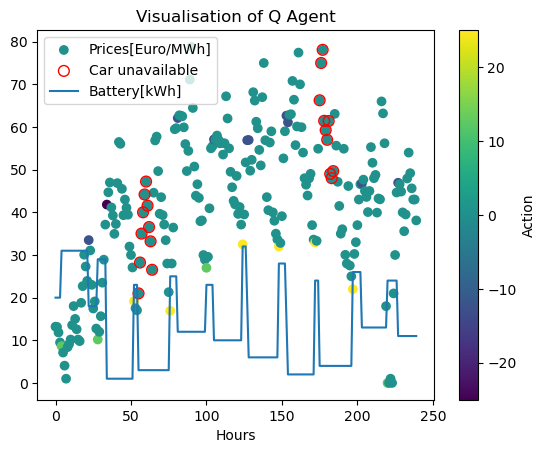

Profit on validation set: -517.19


In [10]:
eval_env = SmartGridEnv(val, seed = 2)
agent.env = eval_env

#storing values for visualisation
no_hours = val.shape[0]*24
actions = []
battery_charges = []
availables = []
hours = np.array(range(no_hours))
h=0
available=True

while not agent.env.done:
    current_state = tuple(agent.env.current_state)
    action_index = agent.predict(current_state)
    action = agent.env.action_space.map_to_action(action_index)
    if available==False:
        battery_charges = battery_charges + list(agent.env.current_battery for i in range(10))
    next_state, reward, done, available = agent.env.step(action_index)
    availables.append(available)
    if available == True:
        actions.append(action)
        battery_charges.append(agent.env.current_battery)
        h=h+1
    if available == False:
        actions = actions + list(int(i) for i in np.zeros(10))
        availables = availables + list(available for i in range(9))
        h=h+10
    
no_days_plot=10


prices = []
[prices.extend(e) for e in val.iloc[0:no_days_plot, 0:24].values]
v=list(availables)

not_available = np.array([index for index, value in enumerate(v) if not value])
actions=np.array(actions)
battery_charges=np.array(battery_charges)
availables=np.array(availables)
hours= np.array(hours)
prices=np.array(prices)
rng= range(no_days_plot*24)


#plotting
f,ax = plt.subplots()
#plotting prices against hours
points = ax.scatter(hours[rng], prices[rng], c=actions[rng], label='Prices[Euro/MWh]')
f.colorbar(points, label='Action')
#add 'unavailable' points
plt.scatter(not_available[not_available<len(rng)],prices[not_available[not_available<len(rng)]], s=60,  marker='o', facecolors='none', edgecolors='r', label='Car unavailable')
plt.title('Visualisation of Q Agent')
plt.xlabel('Hours')
plt.plot(hours[rng], battery_charges[rng], label = 'Battery[kWh]')
plt.legend(loc="upper left")

plt.show()

print(f"Profit on validation set: {eval_env.profit:.2f}")

## Random Agent

Here we implement the random agent. The random agent, as the name suggest, chooses at random how much energy to trade at each decision point.

In [11]:
class RandomAgent(QAgent):
    def __init__(self, env, discount_rate = 0.95, learning_rate=0.3, epsilon=0.5):
        super().__init__(env, discount_rate, learning_rate, epsilon)

    def select_action_random(self):
        mask = self.mask()
        return np.random.choice(np.arange(self.env.action_space.n)[mask])

## Eval Random Agent

Here we evaluate the behaviour of the random agent.

In [12]:
eval_env = SmartGridEnv(val, seed=2)
random_agent = RandomAgent(eval_env)

while not random_agent.env.done:
    current_state = tuple(random_agent.env.current_state)
    action = random_agent.select_action_random()
    print(f"At time {random_agent.env.current_hour +  1} agent transacts {random_agent.env.to_discrete(action)} KWh, price is {random_agent.env.current_price},battery is {random_agent.env.current_battery}.")
    next_state, reward, done, available = random_agent.env.step(action)

print("Profit on validation set: ", random_agent.env.profit)

At time 1 agent transacts -12 KWh, price is 13.2,battery is 20.
At time 2 agent transacts 12 KWh, price is 13.14,battery is 7.
At time 3 agent transacts -12 KWh, price is 11.83,battery is 18.
At time 4 agent transacts 25 KWh, price is 9.49,battery is 5.
At time 5 agent transacts 25 KWh, price is 8.63,battery is 27.
At time 6 agent transacts 0 KWh, price is 7.12,battery is 49.
At time 7 agent transacts -25 KWh, price is 4.06,battery is 49.
At time 8 agent transacts 25 KWh, price is 1.0,battery is 21.
At time 9 agent transacts -12 KWh, price is 8.4,battery is 43.
At time 10 agent transacts 12 KWh, price is 9.11,battery is 30.
At time 11 agent transacts 0 KWh, price is 10.18,battery is 41.
At time 12 agent transacts -25 KWh, price is 13.56,battery is 41.
At time 13 agent transacts 0 KWh, price is 18.02,battery is 13.
At time 14 agent transacts 0 KWh, price is 15.02,battery is 13.
At time 15 agent transacts 12 KWh, price is 12.58,battery is 13.
At time 16 agent transacts 25 KWh, price is 1

At time 24 agent transacts -25 KWh, price is 50.62,battery is 33.
At time 1 agent transacts 0 KWh, price is 47.73,battery is 5.
At time 2 agent transacts 12 KWh, price is 47.78,battery is 5.
At time 3 agent transacts 0 KWh, price is 42.75,battery is 16.
At time 4 agent transacts 12 KWh, price is 32.99,battery is 16.
At time 5 agent transacts -12 KWh, price is 32.0,battery is 27.
At time 6 agent transacts 25 KWh, price is 39.84,battery is 14.
At time 7 agent transacts 12 KWh, price is 48.96,battery is 36.
At time 8 agent transacts 0 KWh, price is 65.0,battery is 47.
At time 18 agent transacts 0 KWh, price is 63.02,battery is 27.
At time 19 agent transacts 0 KWh, price is 67.44,battery is 27.
At time 20 agent transacts 12 KWh, price is 66.99,battery is 27.
At time 21 agent transacts 12 KWh, price is 60.95,battery is 38.
At time 22 agent transacts -12 KWh, price is 50.77,battery is 49.
At time 23 agent transacts 0 KWh, price is 53.06,battery is 36.
At time 24 agent transacts -25 KWh, pric

At time 22 agent transacts 25 KWh, price is 42.42,battery is 20.
At time 23 agent transacts -25 KWh, price is 43.16,battery is 42.
At time 24 agent transacts 25 KWh, price is 42.63,battery is 14.
At time 1 agent transacts -12 KWh, price is 37.71,battery is 36.
At time 2 agent transacts 0 KWh, price is 34.15,battery is 23.
At time 3 agent transacts -12 KWh, price is 31.0,battery is 23.
At time 4 agent transacts 25 KWh, price is 27.0,battery is 10.
At time 5 agent transacts 12 KWh, price is 27.97,battery is 32.
At time 6 agent transacts -12 KWh, price is 33.0,battery is 43.
At time 7 agent transacts 0 KWh, price is 43.45,battery is 30.
At time 8 agent transacts -12 KWh, price is 53.6,battery is 30.
At time 18 agent transacts 25 KWh, price is 60.67,battery is 10.
At time 19 agent transacts 0 KWh, price is 58.85,battery is 32.
At time 20 agent transacts -25 KWh, price is 50.0,battery is 32.
At time 21 agent transacts 12 KWh, price is 49.9,battery is 4.
At time 22 agent transacts 25 KWh, pr

At time 4 agent transacts -12 KWh, price is 16.37,battery is 27.
At time 5 agent transacts 12 KWh, price is 11.77,battery is 14.
At time 6 agent transacts 0 KWh, price is 12.6,battery is 25.
At time 7 agent transacts 25 KWh, price is 15.03,battery is 25.
At time 8 agent transacts 0 KWh, price is 21.82,battery is 47.
At time 18 agent transacts 25 KWh, price is 31.0,battery is 27.
At time 19 agent transacts -12 KWh, price is 43.52,battery is 49.
At time 20 agent transacts -25 KWh, price is 48.69,battery is 36.
At time 21 agent transacts 25 KWh, price is 40.72,battery is 8.
At time 22 agent transacts 0 KWh, price is 33.5,battery is 30.
At time 23 agent transacts 0 KWh, price is 32.99,battery is 30.
At time 24 agent transacts -12 KWh, price is 31.2,battery is 30.
At time 1 agent transacts -12 KWh, price is 22.83,battery is 17.
At time 2 agent transacts 25 KWh, price is 19.43,battery is 4.
At time 3 agent transacts -12 KWh, price is 14.65,battery is 26.
At time 4 agent transacts 0 KWh, pric

At time 22 agent transacts -25 KWh, price is 43.82,battery is 47.
At time 23 agent transacts 12 KWh, price is 42.74,battery is 19.
At time 24 agent transacts -25 KWh, price is 35.0,battery is 30.
At time 1 agent transacts 12 KWh, price is 30.0,battery is 2.
At time 2 agent transacts 25 KWh, price is 29.0,battery is 13.
At time 3 agent transacts -12 KWh, price is 26.0,battery is 35.
At time 4 agent transacts 25 KWh, price is 22.5,battery is 22.
At time 5 agent transacts -12 KWh, price is 23.5,battery is 44.
At time 6 agent transacts -12 KWh, price is 27.51,battery is 31.
At time 7 agent transacts 12 KWh, price is 38.5,battery is 18.
At time 8 agent transacts -25 KWh, price is 45.0,battery is 29.
At time 18 agent transacts 12 KWh, price is 40.0,battery is 9.
At time 19 agent transacts 0 KWh, price is 44.93,battery is 20.
At time 20 agent transacts 12 KWh, price is 54.96,battery is 20.
At time 21 agent transacts -12 KWh, price is 45.9,battery is 31.
At time 22 agent transacts 0 KWh, price

At time 20 agent transacts 0 KWh, price is 49.6,battery is 45.
At time 21 agent transacts -12 KWh, price is 42.5,battery is 45.
At time 22 agent transacts -25 KWh, price is 35.59,battery is 32.
At time 23 agent transacts 25 KWh, price is 35.67,battery is 4.
At time 24 agent transacts 12 KWh, price is 30.69,battery is 26.
At time 1 agent transacts 12 KWh, price is 30.44,battery is 37.
At time 2 agent transacts -12 KWh, price is 27.71,battery is 48.
At time 3 agent transacts 12 KWh, price is 23.46,battery is 35.
At time 4 agent transacts -12 KWh, price is 20.2,battery is 46.
At time 5 agent transacts 0 KWh, price is 18.87,battery is 33.
At time 6 agent transacts -25 KWh, price is 24.22,battery is 33.
At time 7 agent transacts 25 KWh, price is 27.89,battery is 5.
At time 8 agent transacts 0 KWh, price is 30.0,battery is 27.
At time 9 agent transacts 12 KWh, price is 31.63,battery is 27.
At time 10 agent transacts -25 KWh, price is 36.99,battery is 38.
At time 11 agent transacts 0 KWh, pri

At time 5 agent transacts -25 KWh, price is 16.54,battery is 47.
At time 6 agent transacts 12 KWh, price is 17.01,battery is 19.
At time 7 agent transacts 12 KWh, price is 20.0,battery is 30.
At time 8 agent transacts 0 KWh, price is 19.95,battery is 41.
At time 9 agent transacts 0 KWh, price is 26.75,battery is 41.
At time 10 agent transacts 0 KWh, price is 35.4,battery is 41.
At time 11 agent transacts -12 KWh, price is 36.86,battery is 41.
At time 12 agent transacts 0 KWh, price is 37.81,battery is 28.
At time 13 agent transacts 0 KWh, price is 40.0,battery is 28.
At time 14 agent transacts 0 KWh, price is 32.0,battery is 28.
At time 15 agent transacts 12 KWh, price is 29.64,battery is 28.
At time 16 agent transacts -25 KWh, price is 21.99,battery is 39.
At time 17 agent transacts 25 KWh, price is 20.72,battery is 11.
At time 18 agent transacts -25 KWh, price is 25.1,battery is 33.
At time 19 agent transacts 12 KWh, price is 35.37,battery is 5.
At time 20 agent transacts 12 KWh, pri

At time 9 agent transacts 25 KWh, price is 27.51,battery is 12.
At time 10 agent transacts 12 KWh, price is 32.41,battery is 34.
At time 11 agent transacts -12 KWh, price is 34.99,battery is 45.
At time 12 agent transacts 12 KWh, price is 36.96,battery is 32.
At time 13 agent transacts -25 KWh, price is 38.9,battery is 43.
At time 14 agent transacts 0 KWh, price is 33.4,battery is 15.
At time 15 agent transacts -12 KWh, price is 29.13,battery is 15.
At time 16 agent transacts 0 KWh, price is 24.06,battery is 2.
At time 17 agent transacts 25 KWh, price is 16.51,battery is 2.
At time 18 agent transacts 0 KWh, price is 18.39,battery is 24.
At time 19 agent transacts 25 KWh, price is 28.0,battery is 24.
At time 20 agent transacts -25 KWh, price is 30.65,battery is 46.
At time 21 agent transacts 12 KWh, price is 38.7,battery is 18.
At time 22 agent transacts 12 KWh, price is 41.01,battery is 29.
At time 23 agent transacts -25 KWh, price is 44.27,battery is 40.
At time 24 agent transacts 0 K

At time 5 agent transacts 0 KWh, price is 30.0,battery is 24.
At time 6 agent transacts 12 KWh, price is 38.07,battery is 24.
At time 7 agent transacts -12 KWh, price is 42.54,battery is 35.
At time 8 agent transacts 25 KWh, price is 50.66,battery is 22.
At time 18 agent transacts 12 KWh, price is 41.47,battery is 2.
At time 19 agent transacts 0 KWh, price is 43.42,battery is 13.
At time 20 agent transacts 12 KWh, price is 43.46,battery is 13.
At time 21 agent transacts 12 KWh, price is 46.0,battery is 24.
At time 22 agent transacts -12 KWh, price is 46.53,battery is 35.
At time 23 agent transacts 12 KWh, price is 44.83,battery is 22.
At time 24 agent transacts 12 KWh, price is 41.61,battery is 33.
At time 1 agent transacts -25 KWh, price is 42.54,battery is 44.
At time 2 agent transacts 25 KWh, price is 40.04,battery is 16.
At time 3 agent transacts 12 KWh, price is 38.07,battery is 38.
At time 4 agent transacts -12 KWh, price is 32.99,battery is 49.
At time 5 agent transacts 0 KWh, p

At time 12 agent transacts -25 KWh, price is 58.57,battery is 48.
At time 13 agent transacts 12 KWh, price is 57.67,battery is 20.
At time 14 agent transacts 12 KWh, price is 53.08,battery is 31.
At time 15 agent transacts -12 KWh, price is 50.31,battery is 42.
At time 16 agent transacts -12 KWh, price is 49.83,battery is 29.
At time 17 agent transacts 0 KWh, price is 48.0,battery is 16.
At time 18 agent transacts 12 KWh, price is 48.57,battery is 16.
At time 19 agent transacts 12 KWh, price is 50.5,battery is 27.
At time 20 agent transacts -12 KWh, price is 50.92,battery is 38.
At time 21 agent transacts 25 KWh, price is 48.65,battery is 25.
At time 22 agent transacts -25 KWh, price is 45.38,battery is 47.
At time 23 agent transacts -12 KWh, price is 50.3,battery is 19.
At time 24 agent transacts 25 KWh, price is 44.91,battery is 6.
At time 1 agent transacts 12 KWh, price is 43.7,battery is 28.
At time 2 agent transacts 0 KWh, price is 40.7,battery is 39.
At time 3 agent transacts 0 K

At time 7 agent transacts 25 KWh, price is 33.99,battery is 22.
At time 8 agent transacts -12 KWh, price is 43.62,battery is 44.
At time 18 agent transacts 12 KWh, price is 45.0,battery is 24.
At time 19 agent transacts 0 KWh, price is 44.98,battery is 35.
At time 20 agent transacts -12 KWh, price is 44.0,battery is 35.
At time 21 agent transacts -12 KWh, price is 41.99,battery is 22.
At time 22 agent transacts 12 KWh, price is 40.59,battery is 9.
At time 23 agent transacts 12 KWh, price is 43.27,battery is 20.
At time 24 agent transacts 0 KWh, price is 37.98,battery is 31.
At time 1 agent transacts 12 KWh, price is 25.77,battery is 31.
At time 2 agent transacts -25 KWh, price is 17.26,battery is 42.
At time 3 agent transacts 0 KWh, price is 12.26,battery is 14.
At time 4 agent transacts 0 KWh, price is 9.5,battery is 14.
At time 5 agent transacts 12 KWh, price is 10.01,battery is 14.
At time 6 agent transacts 0 KWh, price is 15.53,battery is 25.
At time 7 agent transacts 12 KWh, price

At time 18 agent transacts 0 KWh, price is 49.06,battery is 26.
At time 19 agent transacts 12 KWh, price is 49.06,battery is 26.
At time 20 agent transacts 0 KWh, price is 48.09,battery is 37.
At time 21 agent transacts 12 KWh, price is 43.02,battery is 37.
At time 22 agent transacts 0 KWh, price is 39.76,battery is 48.
At time 23 agent transacts -25 KWh, price is 44.48,battery is 48.
At time 24 agent transacts 25 KWh, price is 38.25,battery is 20.
At time 1 agent transacts -12 KWh, price is 32.66,battery is 42.
At time 2 agent transacts -12 KWh, price is 29.99,battery is 29.
At time 3 agent transacts 25 KWh, price is 21.6,battery is 16.
At time 4 agent transacts -12 KWh, price is 10.49,battery is 38.
At time 5 agent transacts -12 KWh, price is 10.18,battery is 25.
At time 6 agent transacts 12 KWh, price is 17.81,battery is 12.
At time 7 agent transacts 12 KWh, price is 34.04,battery is 23.
At time 8 agent transacts -25 KWh, price is 48.38,battery is 34.
At time 18 agent transacts 0 KW

At time 11 agent transacts 0 KWh, price is 63.86,battery is 44.
At time 12 agent transacts -25 KWh, price is 70.36,battery is 44.
At time 13 agent transacts 0 KWh, price is 64.8,battery is 16.
At time 14 agent transacts 12 KWh, price is 60.76,battery is 16.
At time 15 agent transacts 0 KWh, price is 56.29,battery is 27.
At time 16 agent transacts 0 KWh, price is 51.73,battery is 27.
At time 17 agent transacts 0 KWh, price is 51.98,battery is 27.
At time 18 agent transacts 12 KWh, price is 49.84,battery is 27.
At time 19 agent transacts -25 KWh, price is 50.16,battery is 38.
At time 20 agent transacts 12 KWh, price is 49.34,battery is 10.
At time 21 agent transacts -12 KWh, price is 47.75,battery is 21.
At time 22 agent transacts 0 KWh, price is 50.0,battery is 8.
At time 23 agent transacts 0 KWh, price is 51.0,battery is 8.
At time 24 agent transacts 12 KWh, price is 45.98,battery is 8.
At time 1 agent transacts 0 KWh, price is 42.11,battery is 19.
At time 2 agent transacts -12 KWh, pr

At time 22 agent transacts 0 KWh, price is 46.99,battery is 25.
At time 23 agent transacts -12 KWh, price is 48.54,battery is 25.
At time 24 agent transacts 25 KWh, price is 43.71,battery is 12.
At time 1 agent transacts -12 KWh, price is 42.79,battery is 34.
At time 2 agent transacts 25 KWh, price is 40.09,battery is 21.
At time 3 agent transacts -12 KWh, price is 36.3,battery is 43.
At time 4 agent transacts -25 KWh, price is 31.2,battery is 30.
At time 5 agent transacts 25 KWh, price is 32.21,battery is 2.
At time 6 agent transacts -12 KWh, price is 34.15,battery is 24.
At time 7 agent transacts 25 KWh, price is 36.59,battery is 11.
At time 8 agent transacts 12 KWh, price is 51.07,battery is 33.
At time 9 agent transacts -25 KWh, price is 57.38,battery is 44.
At time 10 agent transacts 25 KWh, price is 58.77,battery is 16.
At time 11 agent transacts 0 KWh, price is 60.07,battery is 38.
At time 12 agent transacts 0 KWh, price is 69.41,battery is 38.
At time 13 agent transacts 12 KWh,

At time 16 agent transacts 0 KWh, price is 50.07,battery is 21.
At time 17 agent transacts 0 KWh, price is 51.79,battery is 21.
At time 18 agent transacts 0 KWh, price is 49.96,battery is 21.
At time 19 agent transacts 0 KWh, price is 50.32,battery is 21.
At time 20 agent transacts -12 KWh, price is 49.29,battery is 21.
At time 21 agent transacts 0 KWh, price is 47.37,battery is 8.
At time 22 agent transacts 12 KWh, price is 47.0,battery is 8.
At time 23 agent transacts -12 KWh, price is 50.81,battery is 19.
At time 24 agent transacts 25 KWh, price is 46.5,battery is 6.
At time 1 agent transacts -25 KWh, price is 44.96,battery is 28.
At time 2 agent transacts 0 KWh, price is 42.06,battery is 0.
At time 3 agent transacts 12 KWh, price is 38.0,battery is 0.
At time 4 agent transacts 0 KWh, price is 28.0,battery is 11.
At time 5 agent transacts 0 KWh, price is 24.03,battery is 11.
At time 6 agent transacts 12 KWh, price is 17.82,battery is 11.
At time 7 agent transacts 12 KWh, price is 11

At time 9 agent transacts 0 KWh, price is 47.7,battery is 42.
At time 10 agent transacts 0 KWh, price is 49.92,battery is 42.
At time 11 agent transacts -25 KWh, price is 49.99,battery is 42.
At time 12 agent transacts 12 KWh, price is 52.89,battery is 14.
At time 13 agent transacts -12 KWh, price is 50.21,battery is 25.
At time 14 agent transacts 25 KWh, price is 49.85,battery is 12.
At time 15 agent transacts -25 KWh, price is 50.02,battery is 34.
At time 16 agent transacts 0 KWh, price is 48.8,battery is 6.
At time 17 agent transacts 12 KWh, price is 47.2,battery is 6.
At time 18 agent transacts -12 KWh, price is 44.88,battery is 17.
At time 19 agent transacts 25 KWh, price is 45.43,battery is 4.
At time 20 agent transacts 25 KWh, price is 44.58,battery is 26.
At time 21 agent transacts -12 KWh, price is 42.89,battery is 48.
At time 22 agent transacts -25 KWh, price is 42.77,battery is 35.
At time 23 agent transacts 25 KWh, price is 45.92,battery is 7.
At time 24 agent transacts -25

At time 12 agent transacts 0 KWh, price is 51.3,battery is 34.
At time 13 agent transacts -12 KWh, price is 50.0,battery is 34.
At time 14 agent transacts 0 KWh, price is 48.71,battery is 21.
At time 15 agent transacts 12 KWh, price is 48.38,battery is 21.
At time 16 agent transacts 12 KWh, price is 47.33,battery is 32.
At time 17 agent transacts -25 KWh, price is 46.54,battery is 43.
At time 18 agent transacts -12 KWh, price is 46.5,battery is 15.
At time 19 agent transacts 0 KWh, price is 47.42,battery is 2.
At time 20 agent transacts 12 KWh, price is 46.65,battery is 2.
At time 21 agent transacts 0 KWh, price is 36.51,battery is 13.
At time 22 agent transacts 25 KWh, price is 43.14,battery is 13.
At time 23 agent transacts 0 KWh, price is 46.5,battery is 35.
At time 24 agent transacts -12 KWh, price is 41.5,battery is 35.
At time 1 agent transacts 0 KWh, price is 13.85,battery is 22.
At time 2 agent transacts -12 KWh, price is 11.98,battery is 22.
At time 3 agent transacts 12 KWh, p

At time 2 agent transacts 12 KWh, price is 33.67,battery is 12.
At time 3 agent transacts 0 KWh, price is 25.86,battery is 23.
At time 4 agent transacts 0 KWh, price is 13.26,battery is 23.
At time 5 agent transacts -12 KWh, price is 12.77,battery is 23.
At time 6 agent transacts 0 KWh, price is 21.87,battery is 10.
At time 7 agent transacts 12 KWh, price is 34.02,battery is 10.
At time 8 agent transacts 25 KWh, price is 44.89,battery is 21.
At time 9 agent transacts -25 KWh, price is 49.61,battery is 43.
At time 10 agent transacts 0 KWh, price is 52.2,battery is 15.
At time 11 agent transacts -12 KWh, price is 55.0,battery is 15.
At time 12 agent transacts 0 KWh, price is 56.29,battery is 2.
At time 13 agent transacts 12 KWh, price is 53.19,battery is 2.
At time 14 agent transacts 12 KWh, price is 51.0,battery is 13.
At time 15 agent transacts 12 KWh, price is 49.0,battery is 24.
At time 16 agent transacts -12 KWh, price is 45.96,battery is 35.
At time 17 agent transacts 25 KWh, price

At time 21 agent transacts -12 KWh, price is 54.29,battery is 26.
At time 22 agent transacts 25 KWh, price is 48.72,battery is 13.
At time 23 agent transacts 0 KWh, price is 49.31,battery is 35.
At time 24 agent transacts -12 KWh, price is 40.57,battery is 35.
At time 1 agent transacts -12 KWh, price is 38.99,battery is 22.
At time 2 agent transacts 0 KWh, price is 37.43,battery is 9.
At time 3 agent transacts 12 KWh, price is 29.99,battery is 9.
At time 4 agent transacts 12 KWh, price is 21.81,battery is 20.
At time 5 agent transacts 0 KWh, price is 26.0,battery is 31.
At time 6 agent transacts -25 KWh, price is 40.2,battery is 31.
At time 7 agent transacts 25 KWh, price is 47.6,battery is 3.
At time 8 agent transacts 25 KWh, price is 52.95,battery is 25.
At time 18 agent transacts 12 KWh, price is 51.88,battery is 5.
At time 19 agent transacts -12 KWh, price is 53.38,battery is 16.
At time 20 agent transacts 25 KWh, price is 55.12,battery is 3.
At time 21 agent transacts 25 KWh, pric

At time 18 agent transacts 0 KWh, price is 45.26,battery is 27.
At time 19 agent transacts 12 KWh, price is 49.39,battery is 27.
At time 20 agent transacts -12 KWh, price is 53.01,battery is 38.
At time 21 agent transacts 0 KWh, price is 54.4,battery is 25.
At time 22 agent transacts 25 KWh, price is 50.19,battery is 25.
At time 23 agent transacts -25 KWh, price is 49.33,battery is 47.
At time 24 agent transacts 25 KWh, price is 47.14,battery is 19.
At time 1 agent transacts -12 KWh, price is 42.01,battery is 41.
At time 2 agent transacts -25 KWh, price is 40.32,battery is 28.
At time 3 agent transacts 0 KWh, price is 36.99,battery is 0.
At time 4 agent transacts 12 KWh, price is 33.23,battery is 0.
At time 5 agent transacts 12 KWh, price is 30.94,battery is 11.
At time 6 agent transacts 12 KWh, price is 31.68,battery is 22.
At time 7 agent transacts 0 KWh, price is 32.29,battery is 33.
At time 8 agent transacts -12 KWh, price is 32.57,battery is 33.
At time 9 agent transacts -12 KWh, 

At time 20 agent transacts -25 KWh, price is 68.02,battery is 35.
At time 21 agent transacts 0 KWh, price is 61.1,battery is 7.
At time 22 agent transacts 25 KWh, price is 52.22,battery is 7.
At time 23 agent transacts 12 KWh, price is 49.54,battery is 29.
At time 24 agent transacts -25 KWh, price is 47.27,battery is 40.
At time 1 agent transacts 0 KWh, price is 44.34,battery is 12.
At time 2 agent transacts 25 KWh, price is 42.62,battery is 12.
At time 3 agent transacts -12 KWh, price is 38.09,battery is 34.
At time 4 agent transacts -12 KWh, price is 35.99,battery is 21.
At time 5 agent transacts 12 KWh, price is 36.06,battery is 8.
At time 6 agent transacts 25 KWh, price is 39.57,battery is 19.
At time 7 agent transacts 0 KWh, price is 49.49,battery is 41.
At time 8 agent transacts -12 KWh, price is 62.5,battery is 41.
At time 9 agent transacts -12 KWh, price is 61.58,battery is 28.
At time 10 agent transacts -12 KWh, price is 61.36,battery is 15.
At time 11 agent transacts 0 KWh, p

At time 18 agent transacts -12 KWh, price is 56.27,battery is 44.
At time 19 agent transacts -12 KWh, price is 67.5,battery is 31.
At time 20 agent transacts 25 KWh, price is 79.35,battery is 18.
At time 21 agent transacts -12 KWh, price is 69.39,battery is 40.
At time 22 agent transacts 0 KWh, price is 59.1,battery is 27.
At time 23 agent transacts 0 KWh, price is 63.19,battery is 27.
At time 24 agent transacts -12 KWh, price is 48.69,battery is 27.
At time 1 agent transacts 25 KWh, price is 53.18,battery is 14.
At time 2 agent transacts -25 KWh, price is 51.01,battery is 36.
At time 3 agent transacts 12 KWh, price is 40.15,battery is 8.
At time 4 agent transacts -12 KWh, price is 39.0,battery is 19.
At time 5 agent transacts 25 KWh, price is 39.96,battery is 6.
At time 6 agent transacts 12 KWh, price is 42.99,battery is 28.
At time 7 agent transacts 0 KWh, price is 64.29,battery is 39.
At time 8 agent transacts 0 KWh, price is 70.88,battery is 39.
At time 9 agent transacts -12 KWh, p

At time 8 agent transacts -25 KWh, price is 211.53,battery is 49.
At time 18 agent transacts 12 KWh, price is 75.55,battery is 29.
At time 19 agent transacts -25 KWh, price is 87.37,battery is 40.
At time 20 agent transacts 0 KWh, price is 104.4,battery is 12.
At time 21 agent transacts 0 KWh, price is 77.92,battery is 12.
At time 22 agent transacts 0 KWh, price is 73.91,battery is 12.
At time 23 agent transacts 0 KWh, price is 72.45,battery is 12.
At time 24 agent transacts 12 KWh, price is 72.21,battery is 12.
At time 1 agent transacts 0 KWh, price is 58.37,battery is 23.
At time 2 agent transacts 25 KWh, price is 56.19,battery is 23.
At time 3 agent transacts -25 KWh, price is 49.08,battery is 45.
At time 4 agent transacts 25 KWh, price is 43.0,battery is 17.
At time 5 agent transacts 0 KWh, price is 37.52,battery is 39.
At time 6 agent transacts 0 KWh, price is 52.29,battery is 39.
At time 7 agent transacts 0 KWh, price is 71.7,battery is 39.
At time 8 agent transacts -25 KWh, pric

At time 12 agent transacts 12 KWh, price is 55.92,battery is 26.
At time 13 agent transacts -12 KWh, price is 56.03,battery is 37.
At time 14 agent transacts 25 KWh, price is 50.32,battery is 24.
At time 15 agent transacts -25 KWh, price is 45.97,battery is 46.
At time 16 agent transacts 0 KWh, price is 44.96,battery is 18.
At time 17 agent transacts 25 KWh, price is 51.47,battery is 18.
At time 18 agent transacts -25 KWh, price is 62.48,battery is 40.
At time 19 agent transacts 25 KWh, price is 64.6,battery is 12.
At time 20 agent transacts -25 KWh, price is 59.95,battery is 34.
At time 21 agent transacts 0 KWh, price is 49.2,battery is 6.
At time 22 agent transacts 12 KWh, price is 41.4,battery is 6.
At time 23 agent transacts 12 KWh, price is 44.42,battery is 17.
At time 24 agent transacts -25 KWh, price is 41.53,battery is 28.
At time 1 agent transacts 0 KWh, price is 42.91,battery is 0.
At time 2 agent transacts 25 KWh, price is 41.44,battery is 0.
At time 3 agent transacts -12 KW

At time 3 agent transacts -12 KWh, price is 52.21,battery is 32.
At time 4 agent transacts 25 KWh, price is 47.03,battery is 19.
At time 5 agent transacts -12 KWh, price is 45.08,battery is 41.
At time 6 agent transacts -25 KWh, price is 44.1,battery is 28.
At time 7 agent transacts 25 KWh, price is 68.49,battery is 0.
At time 8 agent transacts -12 KWh, price is 77.01,battery is 22.
At time 9 agent transacts 12 KWh, price is 70.98,battery is 9.
At time 10 agent transacts 12 KWh, price is 76.91,battery is 20.
At time 11 agent transacts -12 KWh, price is 75.65,battery is 31.
At time 12 agent transacts 25 KWh, price is 75.04,battery is 18.
At time 13 agent transacts -12 KWh, price is 74.9,battery is 40.
At time 14 agent transacts 0 KWh, price is 73.14,battery is 27.
At time 15 agent transacts 0 KWh, price is 72.43,battery is 27.
At time 16 agent transacts -12 KWh, price is 68.87,battery is 27.
At time 17 agent transacts 0 KWh, price is 70.2,battery is 14.
At time 18 agent transacts 0 KWh,

At time 23 agent transacts -12 KWh, price is 64.04,battery is 23.
At time 24 agent transacts 0 KWh, price is 59.89,battery is 10.
At time 1 agent transacts 25 KWh, price is 50.91,battery is 10.
At time 2 agent transacts -25 KWh, price is 49.75,battery is 32.
At time 3 agent transacts 0 KWh, price is 47.04,battery is 4.
At time 4 agent transacts 25 KWh, price is 45.49,battery is 4.
At time 5 agent transacts -12 KWh, price is 45.49,battery is 26.
At time 6 agent transacts 25 KWh, price is 47.58,battery is 13.
At time 7 agent transacts 0 KWh, price is 53.2,battery is 35.
At time 8 agent transacts -12 KWh, price is 70.04,battery is 35.
At time 9 agent transacts 25 KWh, price is 74.93,battery is 22.
At time 10 agent transacts 0 KWh, price is 78.64,battery is 44.
At time 11 agent transacts -25 KWh, price is 77.87,battery is 44.
At time 12 agent transacts -12 KWh, price is 79.94,battery is 16.
At time 13 agent transacts 25 KWh, price is 78.33,battery is 3.
At time 14 agent transacts -12 KWh, 

At time 20 agent transacts -25 KWh, price is 66.17,battery is 40.
At time 21 agent transacts 12 KWh, price is 56.3,battery is 12.
At time 22 agent transacts -12 KWh, price is 50.18,battery is 23.
At time 23 agent transacts 0 KWh, price is 51.15,battery is 10.
At time 24 agent transacts 12 KWh, price is 49.72,battery is 10.
At time 1 agent transacts -12 KWh, price is 49.94,battery is 21.
At time 2 agent transacts 25 KWh, price is 50.33,battery is 8.
At time 3 agent transacts 12 KWh, price is 39.81,battery is 30.
At time 4 agent transacts -25 KWh, price is 29.35,battery is 41.
At time 5 agent transacts 12 KWh, price is 27.9,battery is 13.
At time 6 agent transacts 12 KWh, price is 35.01,battery is 24.
At time 7 agent transacts 0 KWh, price is 47.74,battery is 35.
At time 8 agent transacts -25 KWh, price is 53.01,battery is 35.
At time 18 agent transacts -12 KWh, price is 63.27,battery is 15.
At time 19 agent transacts 12 KWh, price is 62.61,battery is 2.
At time 20 agent transacts 12 KWh

At time 3 agent transacts 0 KWh, price is 46.24,battery is 19.
At time 4 agent transacts 12 KWh, price is 44.14,battery is 19.
At time 5 agent transacts -25 KWh, price is 44.75,battery is 30.
At time 6 agent transacts 0 KWh, price is 46.98,battery is 2.
At time 7 agent transacts 25 KWh, price is 52.86,battery is 2.
At time 8 agent transacts 0 KWh, price is 67.32,battery is 24.
At time 9 agent transacts 12 KWh, price is 68.38,battery is 24.
At time 10 agent transacts -12 KWh, price is 67.78,battery is 35.
At time 11 agent transacts 25 KWh, price is 67.46,battery is 22.
At time 12 agent transacts -25 KWh, price is 67.54,battery is 44.
At time 13 agent transacts 0 KWh, price is 66.25,battery is 16.
At time 14 agent transacts 25 KWh, price is 65.41,battery is 16.
At time 15 agent transacts -25 KWh, price is 64.37,battery is 38.
At time 16 agent transacts 0 KWh, price is 63.41,battery is 10.
At time 17 agent transacts 0 KWh, price is 63.83,battery is 10.
At time 18 agent transacts 0 KWh, pr

At time 24 agent transacts 12 KWh, price is 48.66,battery is 7.
At time 1 agent transacts 12 KWh, price is 47.98,battery is 18.
At time 2 agent transacts 12 KWh, price is 48.12,battery is 29.
At time 3 agent transacts -25 KWh, price is 46.62,battery is 40.
At time 4 agent transacts 0 KWh, price is 44.94,battery is 12.
At time 5 agent transacts 12 KWh, price is 45.04,battery is 12.
At time 6 agent transacts -12 KWh, price is 47.37,battery is 23.
At time 7 agent transacts 25 KWh, price is 53.02,battery is 10.
At time 8 agent transacts 0 KWh, price is 65.87,battery is 32.
At time 18 agent transacts 25 KWh, price is 62.07,battery is 12.
At time 19 agent transacts 12 KWh, price is 68.41,battery is 34.
At time 20 agent transacts -12 KWh, price is 66.7,battery is 45.
At time 21 agent transacts -12 KWh, price is 60.04,battery is 32.
At time 22 agent transacts 12 KWh, price is 50.31,battery is 19.
At time 23 agent transacts -25 KWh, price is 54.58,battery is 30.
At time 24 agent transacts 25 KW

At time 18 agent transacts 12 KWh, price is 47.63,battery is 27.
At time 19 agent transacts 12 KWh, price is 57.16,battery is 38.
At time 20 agent transacts 0 KWh, price is 69.16,battery is 49.
At time 21 agent transacts -12 KWh, price is 63.57,battery is 49.
At time 22 agent transacts -12 KWh, price is 49.93,battery is 36.
At time 23 agent transacts 25 KWh, price is 53.2,battery is 23.
At time 24 agent transacts -12 KWh, price is 51.26,battery is 45.
At time 1 agent transacts 0 KWh, price is 52.74,battery is 32.
At time 2 agent transacts -25 KWh, price is 51.74,battery is 32.
At time 3 agent transacts 12 KWh, price is 48.12,battery is 4.
At time 4 agent transacts 12 KWh, price is 42.11,battery is 15.
At time 5 agent transacts 0 KWh, price is 43.46,battery is 26.
At time 6 agent transacts 25 KWh, price is 49.38,battery is 26.
At time 7 agent transacts -25 KWh, price is 58.12,battery is 48.
At time 8 agent transacts -12 KWh, price is 63.04,battery is 20.
At time 18 agent transacts 25 KW

At time 9 agent transacts 0 KWh, price is 65.6,battery is 40.
At time 10 agent transacts -12 KWh, price is 63.62,battery is 40.
At time 11 agent transacts 0 KWh, price is 60.01,battery is 27.
At time 12 agent transacts 0 KWh, price is 59.19,battery is 27.
At time 13 agent transacts 25 KWh, price is 54.09,battery is 27.
At time 14 agent transacts -25 KWh, price is 51.85,battery is 49.
At time 15 agent transacts 12 KWh, price is 50.09,battery is 21.
At time 16 agent transacts 12 KWh, price is 50.01,battery is 32.
At time 17 agent transacts -12 KWh, price is 49.47,battery is 43.
At time 18 agent transacts -12 KWh, price is 51.07,battery is 30.
At time 19 agent transacts 12 KWh, price is 61.28,battery is 17.
At time 20 agent transacts -25 KWh, price is 71.97,battery is 28.
At time 21 agent transacts 25 KWh, price is 65.34,battery is 0.
At time 22 agent transacts 25 KWh, price is 60.73,battery is 22.
At time 23 agent transacts 0 KWh, price is 59.92,battery is 44.
At time 24 agent transacts 

At time 7 agent transacts -12 KWh, price is 39.26,battery is 40.
At time 8 agent transacts 25 KWh, price is 44.98,battery is 27.
At time 9 agent transacts -12 KWh, price is 47.9,battery is 49.
At time 10 agent transacts -25 KWh, price is 53.48,battery is 36.
At time 11 agent transacts 25 KWh, price is 54.2,battery is 8.
At time 12 agent transacts -12 KWh, price is 55.46,battery is 30.
At time 13 agent transacts -12 KWh, price is 54.06,battery is 17.
At time 14 agent transacts 25 KWh, price is 48.07,battery is 4.
At time 15 agent transacts -12 KWh, price is 44.98,battery is 26.
At time 16 agent transacts 0 KWh, price is 41.95,battery is 13.
At time 17 agent transacts 25 KWh, price is 39.71,battery is 13.
At time 18 agent transacts -12 KWh, price is 38.6,battery is 35.
At time 19 agent transacts 0 KWh, price is 46.4,battery is 22.
At time 20 agent transacts -12 KWh, price is 37.31,battery is 22.
At time 21 agent transacts 0 KWh, price is 45.0,battery is 9.
At time 22 agent transacts 12 K

At time 7 agent transacts 12 KWh, price is 50.6,battery is 10.
At time 8 agent transacts 12 KWh, price is 49.62,battery is 21.
At time 18 agent transacts 12 KWh, price is 49.89,battery is 1.
At time 19 agent transacts 12 KWh, price is 56.19,battery is 12.
At time 20 agent transacts -12 KWh, price is 57.43,battery is 23.
At time 21 agent transacts 0 KWh, price is 61.91,battery is 10.
At time 22 agent transacts 25 KWh, price is 61.96,battery is 10.
At time 23 agent transacts 12 KWh, price is 61.27,battery is 32.
At time 24 agent transacts -25 KWh, price is 52.29,battery is 43.
At time 1 agent transacts 12 KWh, price is 53.19,battery is 15.
At time 2 agent transacts -12 KWh, price is 47.59,battery is 26.
At time 3 agent transacts 25 KWh, price is 41.63,battery is 13.
At time 4 agent transacts -25 KWh, price is 36.21,battery is 35.
At time 5 agent transacts 0 KWh, price is 33.14,battery is 7.
At time 6 agent transacts 0 KWh, price is 41.72,battery is 7.
At time 7 agent transacts 25 KWh, pr

At time 20 agent transacts 0 KWh, price is 61.19,battery is 12.
At time 21 agent transacts 12 KWh, price is 53.28,battery is 12.
At time 22 agent transacts 12 KWh, price is 56.19,battery is 23.
At time 23 agent transacts 12 KWh, price is 63.19,battery is 34.
At time 24 agent transacts -25 KWh, price is 53.17,battery is 45.
At time 1 agent transacts 12 KWh, price is 49.71,battery is 17.
At time 2 agent transacts 12 KWh, price is 44.51,battery is 28.
At time 3 agent transacts -12 KWh, price is 41.15,battery is 39.
At time 4 agent transacts -12 KWh, price is 25.01,battery is 26.
At time 5 agent transacts 12 KWh, price is 23.9,battery is 13.
At time 6 agent transacts 12 KWh, price is 40.32,battery is 24.
At time 7 agent transacts 12 KWh, price is 46.0,battery is 35.
At time 8 agent transacts -25 KWh, price is 56.27,battery is 46.
At time 9 agent transacts -12 KWh, price is 65.11,battery is 18.
At time 10 agent transacts 0 KWh, price is 63.21,battery is 5.
At time 11 agent transacts 25 KWh,

At time 21 agent transacts -12 KWh, price is 66.13,battery is 49.
At time 22 agent transacts 0 KWh, price is 65.17,battery is 36.
At time 23 agent transacts 12 KWh, price is 64.93,battery is 36.
At time 24 agent transacts -12 KWh, price is 53.76,battery is 47.
At time 1 agent transacts 0 KWh, price is 55.6,battery is 34.
At time 2 agent transacts 12 KWh, price is 51.65,battery is 34.
At time 3 agent transacts 0 KWh, price is 50.06,battery is 45.
At time 4 agent transacts -25 KWh, price is 47.24,battery is 45.
At time 5 agent transacts 25 KWh, price is 45.26,battery is 17.
At time 6 agent transacts -25 KWh, price is 49.0,battery is 39.
At time 7 agent transacts 12 KWh, price is 53.2,battery is 11.
At time 8 agent transacts 0 KWh, price is 72.06,battery is 22.
At time 18 agent transacts 0 KWh, price is 67.0,battery is 2.
At time 19 agent transacts 0 KWh, price is 68.19,battery is 2.
At time 20 agent transacts 0 KWh, price is 65.8,battery is 2.
At time 21 agent transacts 0 KWh, price is 6

At time 1 agent transacts 0 KWh, price is 47.0,battery is 16.
At time 2 agent transacts 25 KWh, price is 43.89,battery is 16.
At time 3 agent transacts -12 KWh, price is 26.97,battery is 38.
At time 4 agent transacts 25 KWh, price is 10.47,battery is 25.
At time 5 agent transacts -12 KWh, price is 10.2,battery is 47.
At time 6 agent transacts -25 KWh, price is 26.85,battery is 34.
At time 7 agent transacts 25 KWh, price is 42.84,battery is 6.
At time 8 agent transacts -25 KWh, price is 54.81,battery is 28.
At time 9 agent transacts 0 KWh, price is 58.65,battery is 0.
At time 10 agent transacts 12 KWh, price is 58.84,battery is 0.
At time 11 agent transacts 12 KWh, price is 61.51,battery is 11.
At time 12 agent transacts 25 KWh, price is 65.58,battery is 22.
At time 13 agent transacts 0 KWh, price is 65.09,battery is 44.
At time 14 agent transacts -25 KWh, price is 65.12,battery is 44.
At time 15 agent transacts 12 KWh, price is 61.72,battery is 16.
At time 16 agent transacts 25 KWh, pr

At time 19 agent transacts 12 KWh, price is 57.25,battery is 24.
At time 20 agent transacts 0 KWh, price is 53.2,battery is 35.
At time 21 agent transacts 12 KWh, price is 51.59,battery is 35.
At time 22 agent transacts -25 KWh, price is 50.48,battery is 46.
At time 23 agent transacts 25 KWh, price is 54.0,battery is 18.
At time 24 agent transacts 0 KWh, price is 50.57,battery is 40.
At time 1 agent transacts 0 KWh, price is 42.57,battery is 40.
At time 2 agent transacts -25 KWh, price is 40.2,battery is 40.
At time 3 agent transacts 25 KWh, price is 22.46,battery is 12.
At time 4 agent transacts 12 KWh, price is 12.26,battery is 34.
At time 5 agent transacts -12 KWh, price is 11.86,battery is 45.
At time 6 agent transacts 12 KWh, price is 21.61,battery is 32.
At time 7 agent transacts -12 KWh, price is 37.5,battery is 43.
At time 8 agent transacts -25 KWh, price is 57.05,battery is 30.
At time 18 agent transacts 12 KWh, price is 52.01,battery is 10.
At time 19 agent transacts 12 KWh, 

At time 8 agent transacts -25 KWh, price is 50.54,battery is 31.
At time 9 agent transacts 12 KWh, price is 55.22,battery is 3.
At time 10 agent transacts 12 KWh, price is 54.02,battery is 14.
At time 11 agent transacts 12 KWh, price is 56.51,battery is 25.
At time 12 agent transacts -25 KWh, price is 58.63,battery is 36.
At time 13 agent transacts 12 KWh, price is 57.98,battery is 8.
At time 14 agent transacts -12 KWh, price is 58.1,battery is 19.
At time 15 agent transacts 0 KWh, price is 56.28,battery is 6.
At time 16 agent transacts 0 KWh, price is 54.95,battery is 6.
At time 17 agent transacts 12 KWh, price is 55.74,battery is 6.
At time 18 agent transacts 12 KWh, price is 54.06,battery is 17.
At time 19 agent transacts -12 KWh, price is 56.16,battery is 28.
At time 20 agent transacts 25 KWh, price is 55.41,battery is 15.
At time 21 agent transacts -12 KWh, price is 45.62,battery is 37.
At time 22 agent transacts 25 KWh, price is 44.46,battery is 24.
At time 23 agent transacts -25

At time 18 agent transacts 12 KWh, price is 18.38,battery is 6.
At time 19 agent transacts 0 KWh, price is 39.38,battery is 17.
At time 20 agent transacts -12 KWh, price is 45.04,battery is 17.
At time 21 agent transacts 25 KWh, price is 44.69,battery is 4.
At time 22 agent transacts 25 KWh, price is 43.99,battery is 26.
At time 23 agent transacts -12 KWh, price is 44.76,battery is 48.
At time 24 agent transacts -25 KWh, price is 35.02,battery is 35.
At time 1 agent transacts 0 KWh, price is 13.47,battery is 7.
At time 2 agent transacts 0 KWh, price is 10.04,battery is 7.
At time 3 agent transacts 25 KWh, price is 4.15,battery is 7.
At time 4 agent transacts 0 KWh, price is 9.9,battery is 29.
At time 5 agent transacts 12 KWh, price is 5.48,battery is 29.
At time 6 agent transacts -12 KWh, price is 11.25,battery is 40.
At time 7 agent transacts 12 KWh, price is 12.93,battery is 27.
At time 8 agent transacts -25 KWh, price is 18.15,battery is 38.
At time 9 agent transacts 25 KWh, price i

At time 24 agent transacts 0 KWh, price is 50.0,battery is 9.
At time 1 agent transacts 0 KWh, price is 45.84,battery is 9.
At time 2 agent transacts 0 KWh, price is 42.91,battery is 9.
At time 3 agent transacts 25 KWh, price is 40.01,battery is 9.
At time 4 agent transacts 12 KWh, price is 38.58,battery is 31.
At time 5 agent transacts 0 KWh, price is 37.71,battery is 42.
At time 6 agent transacts 0 KWh, price is 40.29,battery is 42.
At time 7 agent transacts -12 KWh, price is 48.93,battery is 42.
At time 8 agent transacts 0 KWh, price is 54.52,battery is 29.
At time 18 agent transacts 12 KWh, price is 59.66,battery is 9.
At time 19 agent transacts 12 KWh, price is 61.19,battery is 20.
At time 20 agent transacts -25 KWh, price is 59.16,battery is 31.
At time 21 agent transacts 12 KWh, price is 57.84,battery is 3.
At time 22 agent transacts 25 KWh, price is 56.72,battery is 14.
At time 23 agent transacts 0 KWh, price is 55.78,battery is 36.
At time 24 agent transacts -12 KWh, price is 

At time 14 agent transacts 0 KWh, price is 67.99,battery is 27.
At time 15 agent transacts -12 KWh, price is 64.93,battery is 27.
At time 16 agent transacts 25 KWh, price is 61.28,battery is 14.
At time 17 agent transacts -12 KWh, price is 59.06,battery is 36.
At time 18 agent transacts 0 KWh, price is 57.02,battery is 23.
At time 19 agent transacts 12 KWh, price is 61.28,battery is 23.
At time 20 agent transacts 12 KWh, price is 61.24,battery is 34.
At time 21 agent transacts -12 KWh, price is 59.38,battery is 45.
At time 22 agent transacts 0 KWh, price is 56.37,battery is 32.
At time 23 agent transacts 0 KWh, price is 57.64,battery is 32.
At time 24 agent transacts 0 KWh, price is 50.97,battery is 32.
At time 1 agent transacts -12 KWh, price is 48.12,battery is 32.
At time 2 agent transacts 12 KWh, price is 44.85,battery is 19.
At time 3 agent transacts 0 KWh, price is 43.99,battery is 30.
At time 4 agent transacts 0 KWh, price is 25.53,battery is 30.
At time 5 agent transacts 12 KWh

At time 22 agent transacts -12 KWh, price is 59.3,battery is 29.
At time 23 agent transacts -12 KWh, price is 53.19,battery is 16.
At time 24 agent transacts 0 KWh, price is 44.91,battery is 3.
At time 1 agent transacts 12 KWh, price is 46.94,battery is 3.
At time 2 agent transacts 25 KWh, price is 41.31,battery is 14.
At time 3 agent transacts -12 KWh, price is 35.29,battery is 36.
At time 4 agent transacts 12 KWh, price is 17.16,battery is 23.
At time 5 agent transacts 12 KWh, price is 12.4,battery is 34.
At time 6 agent transacts -25 KWh, price is 35.32,battery is 45.
At time 7 agent transacts 12 KWh, price is 53.2,battery is 17.
At time 8 agent transacts -25 KWh, price is 61.64,battery is 28.
At time 9 agent transacts 12 KWh, price is 65.73,battery is 0.
At time 10 agent transacts 0 KWh, price is 63.99,battery is 11.
At time 11 agent transacts 12 KWh, price is 61.95,battery is 11.
At time 12 agent transacts 12 KWh, price is 62.09,battery is 22.
At time 13 agent transacts -25 KWh, p

At time 24 agent transacts -25 KWh, price is 44.94,battery is 46.
At time 1 agent transacts 12 KWh, price is 44.0,battery is 18.
At time 2 agent transacts -25 KWh, price is 39.63,battery is 29.
At time 3 agent transacts 25 KWh, price is 29.5,battery is 1.
At time 4 agent transacts 0 KWh, price is 15.77,battery is 23.
At time 5 agent transacts 25 KWh, price is 19.8,battery is 23.
At time 6 agent transacts 0 KWh, price is 31.45,battery is 45.
At time 7 agent transacts 0 KWh, price is 54.93,battery is 45.
At time 8 agent transacts 0 KWh, price is 66.25,battery is 45.
At time 18 agent transacts 12 KWh, price is 61.52,battery is 25.
At time 19 agent transacts 12 KWh, price is 68.57,battery is 36.
At time 20 agent transacts 0 KWh, price is 78.61,battery is 47.
At time 21 agent transacts 0 KWh, price is 75.25,battery is 47.
At time 22 agent transacts -25 KWh, price is 59.98,battery is 47.
At time 23 agent transacts 12 KWh, price is 53.69,battery is 19.
At time 24 agent transacts -12 KWh, pric

At time 4 agent transacts 12 KWh, price is 32.72,battery is 8.
At time 5 agent transacts -12 KWh, price is 31.43,battery is 19.
At time 6 agent transacts 25 KWh, price is 33.2,battery is 6.
At time 7 agent transacts 12 KWh, price is 34.61,battery is 28.
At time 8 agent transacts 0 KWh, price is 38.48,battery is 39.
At time 9 agent transacts -12 KWh, price is 42.1,battery is 39.
At time 10 agent transacts 0 KWh, price is 44.87,battery is 26.
At time 11 agent transacts 25 KWh, price is 45.12,battery is 26.
At time 12 agent transacts -25 KWh, price is 47.43,battery is 48.
At time 13 agent transacts 0 KWh, price is 46.85,battery is 20.
At time 14 agent transacts -12 KWh, price is 42.1,battery is 20.
At time 15 agent transacts 12 KWh, price is 39.76,battery is 7.
At time 16 agent transacts 0 KWh, price is 37.02,battery is 18.
At time 17 agent transacts 25 KWh, price is 42.1,battery is 18.
At time 18 agent transacts -25 KWh, price is 45.12,battery is 40.
At time 19 agent transacts 25 KWh, pr

At time 19 agent transacts 12 KWh, price is 63.47,battery is 28.
At time 20 agent transacts -12 KWh, price is 68.56,battery is 39.
At time 21 agent transacts 0 KWh, price is 57.25,battery is 26.
At time 22 agent transacts 25 KWh, price is 47.65,battery is 26.
At time 23 agent transacts -25 KWh, price is 48.1,battery is 48.
At time 24 agent transacts 0 KWh, price is 48.08,battery is 20.
At time 1 agent transacts 0 KWh, price is 41.34,battery is 20.
At time 2 agent transacts 25 KWh, price is 41.58,battery is 20.
At time 3 agent transacts -12 KWh, price is 50.09,battery is 42.
At time 4 agent transacts -25 KWh, price is 49.0,battery is 29.
At time 5 agent transacts 25 KWh, price is 29.26,battery is 1.
At time 6 agent transacts 25 KWh, price is 28.96,battery is 23.
At time 7 agent transacts 0 KWh, price is 30.0,battery is 45.
At time 8 agent transacts -25 KWh, price is 31.95,battery is 45.
At time 18 agent transacts 0 KWh, price is 47.18,battery is 25.
At time 19 agent transacts -12 KWh, p

At time 22 agent transacts -25 KWh, price is 48.0,battery is 37.
At time 23 agent transacts 12 KWh, price is 50.0,battery is 9.
At time 24 agent transacts 25 KWh, price is 46.81,battery is 20.
At time 1 agent transacts -25 KWh, price is 43.95,battery is 42.
At time 2 agent transacts 0 KWh, price is 40.56,battery is 14.
At time 3 agent transacts 0 KWh, price is 39.45,battery is 14.
At time 4 agent transacts 0 KWh, price is 38.15,battery is 14.
At time 5 agent transacts 0 KWh, price is 38.85,battery is 14.
At time 6 agent transacts 0 KWh, price is 41.06,battery is 14.
At time 7 agent transacts 25 KWh, price is 46.99,battery is 14.
At time 8 agent transacts -12 KWh, price is 64.27,battery is 36.
At time 18 agent transacts 0 KWh, price is 85.1,battery is 16.
At time 19 agent transacts -12 KWh, price is 102.2,battery is 16.
At time 20 agent transacts 25 KWh, price is 76.87,battery is 3.
At time 21 agent transacts -12 KWh, price is 57.9,battery is 25.
At time 22 agent transacts 0 KWh, price 

At time 1 agent transacts 25 KWh, price is 45.5,battery is 13.
At time 2 agent transacts 0 KWh, price is 42.57,battery is 35.
At time 3 agent transacts -25 KWh, price is 41.27,battery is 35.
At time 4 agent transacts 25 KWh, price is 34.46,battery is 7.
At time 5 agent transacts 12 KWh, price is 33.04,battery is 29.
At time 6 agent transacts 0 KWh, price is 40.28,battery is 40.
At time 7 agent transacts 0 KWh, price is 49.29,battery is 40.
At time 8 agent transacts -12 KWh, price is 60.99,battery is 40.
At time 18 agent transacts 25 KWh, price is 71.95,battery is 20.
At time 19 agent transacts -25 KWh, price is 75.39,battery is 42.
At time 20 agent transacts 25 KWh, price is 65.73,battery is 14.
At time 21 agent transacts 0 KWh, price is 60.0,battery is 36.
At time 22 agent transacts 12 KWh, price is 51.08,battery is 36.
At time 23 agent transacts 0 KWh, price is 50.68,battery is 47.
At time 24 agent transacts 0 KWh, price is 45.97,battery is 47.
At time 1 agent transacts 0 KWh, price 

At time 24 agent transacts 25 KWh, price is 43.31,battery is 26.
At time 1 agent transacts -25 KWh, price is 48.06,battery is 48.
At time 2 agent transacts -12 KWh, price is 43.72,battery is 20.
At time 3 agent transacts 0 KWh, price is 37.55,battery is 7.
At time 4 agent transacts 0 KWh, price is 35.02,battery is 7.
At time 5 agent transacts 0 KWh, price is 35.05,battery is 7.
At time 6 agent transacts 25 KWh, price is 41.21,battery is 7.
At time 7 agent transacts 0 KWh, price is 47.76,battery is 29.
At time 8 agent transacts 12 KWh, price is 56.35,battery is 29.
At time 18 agent transacts 25 KWh, price is 56.74,battery is 9.
At time 19 agent transacts 12 KWh, price is 61.97,battery is 31.
At time 20 agent transacts -25 KWh, price is 57.72,battery is 42.
At time 21 agent transacts 25 KWh, price is 53.15,battery is 14.
At time 22 agent transacts -25 KWh, price is 47.13,battery is 36.
At time 23 agent transacts 0 KWh, price is 51.62,battery is 8.
At time 24 agent transacts 25 KWh, price

At time 21 agent transacts 12 KWh, price is 32.95,battery is 0.
At time 22 agent transacts 25 KWh, price is 30.75,battery is 11.
At time 23 agent transacts -12 KWh, price is 35.88,battery is 33.
At time 24 agent transacts -12 KWh, price is 31.45,battery is 20.
At time 1 agent transacts 12 KWh, price is 27.18,battery is 7.
At time 2 agent transacts 12 KWh, price is 25.08,battery is 18.
At time 3 agent transacts -25 KWh, price is 20.96,battery is 29.
At time 4 agent transacts 0 KWh, price is 15.68,battery is 1.
At time 5 agent transacts 25 KWh, price is 10.85,battery is 1.
At time 6 agent transacts 25 KWh, price is 10.53,battery is 23.
At time 7 agent transacts -12 KWh, price is 11.33,battery is 45.
At time 8 agent transacts 12 KWh, price is 10.89,battery is 32.
At time 18 agent transacts 0 KWh, price is 30.09,battery is 12.
At time 19 agent transacts 12 KWh, price is 34.94,battery is 12.
At time 20 agent transacts 25 KWh, price is 38.94,battery is 23.
At time 21 agent transacts -25 KWh,

## Moving Average Agent

Here we implement a 6-hour Moving Average (MA) model. At each time step, we compute the 6-hour moving average, providing a smoothed representation of the electricity price through regularly updated averaged values. The buying/selling policy of this model is based on a comparison with the current price: if the present price exceeds twice the average price, the model sells; conversely, if the current price is half the average price, the model buys. It otherwise just holds, maintaining its current position without any buying or selling actions in the absence of these specific conditions.

In [13]:
class MAgent(QAgent):
    def __init__(self, env, discount_rate = 0.95, learning_rate=0.3, epsilon=0.5, window=6):
        super().__init__(env, discount_rate, learning_rate, epsilon)
        self.price_history = [0 for x in range(window)]
        self.actions = np.arange(self.env.action_space.n)

    def select_action_avg(self):
        mask = self.mask()

        # bookkeep prices
        avg_price_6h = np.mean(self.price_history)
        current_price = self.env.current_price
        self.price_history.pop(0)
        self.price_history.append(current_price)

        # Sell when twice as high
        if current_price > 2 * avg_price_6h:
            action = np.min(self.actions[mask])
        
        # Buy when low
        elif current_price < 0.5 * avg_price_6h:
            action = np.max(self.actions[mask])
        
        # hold if possible
        else:
            if mask[2] == True:
                action = 2
            else:
                action =  np.random.choice(self.actions[mask])        
        return action

## Eval Moving Average Agent

Here we evaluate the behaviour of the moving average agent.

In [14]:
eval_env = SmartGridEnv(val, seed=2)
average_agent = MAgent(eval_env)

while not average_agent.env.done:
    current_state = tuple(average_agent.env.current_state)
    action = average_agent.select_action_avg()
    print(f"at time {average_agent.env.current_hour +  1} agent transacts {average_agent.env.to_discrete(action)} KWh, price is {average_agent.env.current_price},battery is {average_agent.env.current_battery}")
    next_state, reward, done, available = average_agent.env.step(action)

print("Profit on validation set: ", average_agent.env.profit)

at time 1 agent transacts -12 KWh, price is 13.2,battery is 20
at time 2 agent transacts 0 KWh, price is 13.14,battery is 7
at time 3 agent transacts 0 KWh, price is 11.83,battery is 7
at time 4 agent transacts 0 KWh, price is 9.49,battery is 7
at time 5 agent transacts 0 KWh, price is 8.63,battery is 7
at time 6 agent transacts 0 KWh, price is 7.12,battery is 7
at time 7 agent transacts 25 KWh, price is 4.06,battery is 7
at time 8 agent transacts 12 KWh, price is 1.0,battery is 29
at time 9 agent transacts 0 KWh, price is 8.4,battery is 40
at time 10 agent transacts 0 KWh, price is 9.11,battery is 40
at time 11 agent transacts 0 KWh, price is 10.18,battery is 40
at time 12 agent transacts -25 KWh, price is 13.56,battery is 40
at time 13 agent transacts 0 KWh, price is 18.02,battery is 12
at time 14 agent transacts 0 KWh, price is 15.02,battery is 12
at time 15 agent transacts 0 KWh, price is 12.58,battery is 12
at time 16 agent transacts 0 KWh, price is 10.18,battery is 12
at time 17 

at time 24 agent transacts 0 KWh, price is 43.05,battery is 26
at time 1 agent transacts 0 KWh, price is 66.0,battery is 26
at time 2 agent transacts 0 KWh, price is 63.19,battery is 26
at time 3 agent transacts 0 KWh, price is 56.18,battery is 26
at time 4 agent transacts 25 KWh, price is 18.0,battery is 26
at time 5 agent transacts 0 KWh, price is 0.01,battery is 48
at time 6 agent transacts 0 KWh, price is 0.01,battery is 48
at time 7 agent transacts 0 KWh, price is 1.0,battery is 48
at time 8 agent transacts 0 KWh, price is 0.01,battery is 48
at time 9 agent transacts 0 KWh, price is 20.99,battery is 48
at time 10 agent transacts -25 KWh, price is 30.0,battery is 48
at time 11 agent transacts -12 KWh, price is 44.65,battery is 20
at time 12 agent transacts 0 KWh, price is 46.93,battery is 7
at time 13 agent transacts 0 KWh, price is 46.6,battery is 7
at time 14 agent transacts 0 KWh, price is 44.86,battery is 7
at time 15 agent transacts 0 KWh, price is 39.99,battery is 7
at time 1

at time 2 agent transacts 0 KWh, price is 41.83,battery is 29
at time 3 agent transacts 0 KWh, price is 40.09,battery is 29
at time 4 agent transacts 0 KWh, price is 33.28,battery is 29
at time 5 agent transacts 0 KWh, price is 26.67,battery is 29
at time 6 agent transacts 0 KWh, price is 22.0,battery is 29
at time 7 agent transacts 0 KWh, price is 20.05,battery is 29
at time 8 agent transacts 0 KWh, price is 27.85,battery is 29
at time 18 agent transacts 0 KWh, price is 42.15,battery is 9
at time 19 agent transacts 0 KWh, price is 50.08,battery is 9
at time 20 agent transacts 0 KWh, price is 49.48,battery is 9
at time 21 agent transacts 0 KWh, price is 45.68,battery is 9
at time 22 agent transacts 0 KWh, price is 42.42,battery is 9
at time 23 agent transacts 0 KWh, price is 43.16,battery is 9
at time 24 agent transacts 0 KWh, price is 42.63,battery is 9
at time 1 agent transacts 0 KWh, price is 37.71,battery is 9
at time 2 agent transacts 0 KWh, price is 34.15,battery is 9
at time 3 a

at time 18 agent transacts -12 KWh, price is 48.36,battery is 22
at time 19 agent transacts 0 KWh, price is 55.0,battery is 9
at time 20 agent transacts 0 KWh, price is 50.0,battery is 9
at time 21 agent transacts 0 KWh, price is 45.0,battery is 9
at time 22 agent transacts 0 KWh, price is 41.28,battery is 9
at time 23 agent transacts 0 KWh, price is 43.67,battery is 9
at time 24 agent transacts 0 KWh, price is 51.75,battery is 9
at time 1 agent transacts 0 KWh, price is 36.5,battery is 9
at time 2 agent transacts 0 KWh, price is 34.0,battery is 9
at time 3 agent transacts 0 KWh, price is 30.65,battery is 9
at time 4 agent transacts 0 KWh, price is 29.93,battery is 9
at time 5 agent transacts 0 KWh, price is 27.8,battery is 9
at time 6 agent transacts 0 KWh, price is 31.0,battery is 9
at time 7 agent transacts 25 KWh, price is 69.57,battery is 9
at time 8 agent transacts 0 KWh, price is 74.23,battery is 31
at time 9 agent transacts 0 KWh, price is 63.54,battery is 31
at time 10 agent t

at time 6 agent transacts 0 KWh, price is 30.0,battery is 30
at time 7 agent transacts 0 KWh, price is 45.0,battery is 30
at time 8 agent transacts 0 KWh, price is 58.76,battery is 30
at time 18 agent transacts 0 KWh, price is 44.0,battery is 10
at time 19 agent transacts 0 KWh, price is 56.28,battery is 10
at time 20 agent transacts 0 KWh, price is 71.36,battery is 10
at time 21 agent transacts 0 KWh, price is 55.91,battery is 10
at time 22 agent transacts 0 KWh, price is 43.0,battery is 10
at time 23 agent transacts 0 KWh, price is 40.34,battery is 10
at time 24 agent transacts 0 KWh, price is 40.0,battery is 10
at time 1 agent transacts 0 KWh, price is 34.0,battery is 10
at time 2 agent transacts 0 KWh, price is 32.69,battery is 10
at time 3 agent transacts 0 KWh, price is 30.0,battery is 10
at time 4 agent transacts 0 KWh, price is 29.88,battery is 10
at time 5 agent transacts 0 KWh, price is 29.72,battery is 10
at time 6 agent transacts 0 KWh, price is 29.9,battery is 10
at time 7

at time 3 agent transacts 0 KWh, price is 23.46,battery is 22
at time 4 agent transacts 0 KWh, price is 20.2,battery is 22
at time 5 agent transacts 0 KWh, price is 18.87,battery is 22
at time 6 agent transacts 0 KWh, price is 24.22,battery is 22
at time 7 agent transacts 0 KWh, price is 27.89,battery is 22
at time 8 agent transacts 0 KWh, price is 30.0,battery is 22
at time 18 agent transacts 0 KWh, price is 32.69,battery is 2
at time 19 agent transacts 0 KWh, price is 38.86,battery is 2
at time 20 agent transacts 0 KWh, price is 49.57,battery is 2
at time 21 agent transacts 0 KWh, price is 40.0,battery is 2
at time 22 agent transacts 0 KWh, price is 36.56,battery is 2
at time 23 agent transacts 0 KWh, price is 35.61,battery is 2
at time 24 agent transacts 0 KWh, price is 30.5,battery is 2
at time 1 agent transacts 0 KWh, price is 34.88,battery is 2
at time 2 agent transacts 0 KWh, price is 27.47,battery is 2
at time 3 agent transacts 0 KWh, price is 20.21,battery is 2
at time 4 agent

at time 22 agent transacts 0 KWh, price is 47.12,battery is 36
at time 23 agent transacts 0 KWh, price is 44.63,battery is 36
at time 24 agent transacts 0 KWh, price is 42.61,battery is 36
at time 1 agent transacts 0 KWh, price is 36.2,battery is 36
at time 2 agent transacts 0 KWh, price is 32.96,battery is 36
at time 3 agent transacts 0 KWh, price is 28.75,battery is 36
at time 4 agent transacts 0 KWh, price is 25.39,battery is 36
at time 5 agent transacts 0 KWh, price is 26.37,battery is 36
at time 6 agent transacts 0 KWh, price is 33.46,battery is 36
at time 7 agent transacts 0 KWh, price is 49.39,battery is 36
at time 8 agent transacts 0 KWh, price is 61.26,battery is 36
at time 18 agent transacts 0 KWh, price is 44.85,battery is 16
at time 19 agent transacts 0 KWh, price is 47.36,battery is 16
at time 20 agent transacts 0 KWh, price is 48.8,battery is 16
at time 21 agent transacts 0 KWh, price is 54.82,battery is 16
at time 22 agent transacts 0 KWh, price is 49.49,battery is 16
at

at time 4 agent transacts 0 KWh, price is 25.62,battery is 3
at time 5 agent transacts 0 KWh, price is 25.9,battery is 3
at time 6 agent transacts 0 KWh, price is 33.36,battery is 3
at time 7 agent transacts 25 KWh, price is 43.0,battery is 3
at time 8 agent transacts 0 KWh, price is 56.19,battery is 25
at time 9 agent transacts 0 KWh, price is 62.88,battery is 25
at time 10 agent transacts 0 KWh, price is 65.0,battery is 25
at time 11 agent transacts 0 KWh, price is 63.0,battery is 25
at time 12 agent transacts 0 KWh, price is 63.32,battery is 25
at time 13 agent transacts 0 KWh, price is 58.7,battery is 25
at time 14 agent transacts 0 KWh, price is 56.6,battery is 25
at time 15 agent transacts 0 KWh, price is 54.1,battery is 25
at time 16 agent transacts 0 KWh, price is 49.73,battery is 25
at time 17 agent transacts 0 KWh, price is 47.36,battery is 25
at time 18 agent transacts 0 KWh, price is 46.25,battery is 25
at time 19 agent transacts 0 KWh, price is 48.73,battery is 25
at time 

at time 7 agent transacts 0 KWh, price is 36.52,battery is 31
at time 8 agent transacts 0 KWh, price is 45.8,battery is 31
at time 9 agent transacts 0 KWh, price is 51.51,battery is 31
at time 10 agent transacts 0 KWh, price is 51.2,battery is 31
at time 11 agent transacts 0 KWh, price is 51.38,battery is 31
at time 12 agent transacts 0 KWh, price is 51.73,battery is 31
at time 13 agent transacts 0 KWh, price is 51.0,battery is 31
at time 14 agent transacts 0 KWh, price is 50.46,battery is 31
at time 15 agent transacts 0 KWh, price is 49.76,battery is 31
at time 16 agent transacts 0 KWh, price is 48.26,battery is 31
at time 17 agent transacts 0 KWh, price is 46.66,battery is 31
at time 18 agent transacts 0 KWh, price is 45.94,battery is 31
at time 19 agent transacts 0 KWh, price is 46.63,battery is 31
at time 20 agent transacts 0 KWh, price is 45.0,battery is 31
at time 21 agent transacts 0 KWh, price is 45.4,battery is 31
at time 22 agent transacts 0 KWh, price is 46.77,battery is 31


at time 14 agent transacts 0 KWh, price is 56.0,battery is 25
at time 15 agent transacts 0 KWh, price is 53.9,battery is 25
at time 16 agent transacts 0 KWh, price is 54.46,battery is 25
at time 17 agent transacts 0 KWh, price is 53.02,battery is 25
at time 18 agent transacts 0 KWh, price is 51.2,battery is 25
at time 19 agent transacts 0 KWh, price is 51.0,battery is 25
at time 20 agent transacts 0 KWh, price is 49.87,battery is 25
at time 21 agent transacts 0 KWh, price is 49.36,battery is 25
at time 22 agent transacts 0 KWh, price is 49.84,battery is 25
at time 23 agent transacts 0 KWh, price is 50.04,battery is 25
at time 24 agent transacts 0 KWh, price is 45.3,battery is 25
at time 1 agent transacts 0 KWh, price is 48.73,battery is 25
at time 2 agent transacts 0 KWh, price is 44.09,battery is 25
at time 3 agent transacts 0 KWh, price is 40.99,battery is 25
at time 4 agent transacts 0 KWh, price is 36.46,battery is 25
at time 5 agent transacts 0 KWh, price is 33.85,battery is 25
at

at time 24 agent transacts 0 KWh, price is 42.0,battery is 26
at time 1 agent transacts 0 KWh, price is 38.5,battery is 26
at time 2 agent transacts 0 KWh, price is 35.0,battery is 26
at time 3 agent transacts 0 KWh, price is 31.0,battery is 26
at time 4 agent transacts 0 KWh, price is 29.43,battery is 26
at time 5 agent transacts 0 KWh, price is 29.7,battery is 26
at time 6 agent transacts 0 KWh, price is 34.2,battery is 26
at time 7 agent transacts 0 KWh, price is 40.05,battery is 26
at time 8 agent transacts 0 KWh, price is 54.72,battery is 26
at time 9 agent transacts 0 KWh, price is 56.06,battery is 26
at time 10 agent transacts 0 KWh, price is 59.5,battery is 26
at time 11 agent transacts 0 KWh, price is 61.77,battery is 26
at time 12 agent transacts 0 KWh, price is 63.2,battery is 26
at time 13 agent transacts 0 KWh, price is 58.85,battery is 26
at time 14 agent transacts 0 KWh, price is 54.09,battery is 26
at time 15 agent transacts 0 KWh, price is 54.22,battery is 26
at time 1

at time 18 agent transacts 0 KWh, price is 16.29,battery is 13
at time 19 agent transacts 0 KWh, price is 20.25,battery is 13
at time 20 agent transacts 0 KWh, price is 20.56,battery is 13
at time 21 agent transacts 0 KWh, price is 20.0,battery is 13
at time 22 agent transacts 0 KWh, price is 21.53,battery is 13
at time 23 agent transacts 0 KWh, price is 40.1,battery is 13
at time 24 agent transacts 0 KWh, price is 35.0,battery is 13
at time 1 agent transacts 25 KWh, price is 10.17,battery is 13
at time 2 agent transacts 12 KWh, price is 9.49,battery is 35
at time 3 agent transacts 0 KWh, price is 7.09,battery is 46
at time 4 agent transacts 0 KWh, price is 3.52,battery is 46
at time 5 agent transacts 0 KWh, price is 6.48,battery is 46
at time 6 agent transacts 0 KWh, price is 9.5,battery is 46
at time 7 agent transacts -12 KWh, price is 27.5,battery is 46
at time 8 agent transacts -25 KWh, price is 48.63,battery is 33
at time 9 agent transacts 0 KWh, price is 48.63,battery is 5
at tim

at time 7 agent transacts 25 KWh, price is 25.18,battery is 5
at time 8 agent transacts 0 KWh, price is 34.4,battery is 27
at time 18 agent transacts 0 KWh, price is 36.31,battery is 7
at time 19 agent transacts 0 KWh, price is 39.0,battery is 7
at time 20 agent transacts 0 KWh, price is 39.09,battery is 7
at time 21 agent transacts 0 KWh, price is 36.17,battery is 7
at time 22 agent transacts 0 KWh, price is 35.44,battery is 7
at time 23 agent transacts 0 KWh, price is 41.0,battery is 7
at time 24 agent transacts 0 KWh, price is 37.5,battery is 7
at time 1 agent transacts 0 KWh, price is 24.11,battery is 7
at time 2 agent transacts 25 KWh, price is 17.01,battery is 7
at time 3 agent transacts 12 KWh, price is 9.19,battery is 29
at time 4 agent transacts 0 KWh, price is 7.0,battery is 40
at time 5 agent transacts 0 KWh, price is 6.01,battery is 40
at time 6 agent transacts 0 KWh, price is 2.13,battery is 40
at time 7 agent transacts 0 KWh, price is 2.0,battery is 40
at time 8 agent tra

at time 13 agent transacts 0 KWh, price is 64.8,battery is 23
at time 14 agent transacts 0 KWh, price is 60.76,battery is 23
at time 15 agent transacts 0 KWh, price is 56.29,battery is 23
at time 16 agent transacts 0 KWh, price is 51.73,battery is 23
at time 17 agent transacts 0 KWh, price is 51.98,battery is 23
at time 18 agent transacts 0 KWh, price is 49.84,battery is 23
at time 19 agent transacts 0 KWh, price is 50.16,battery is 23
at time 20 agent transacts 0 KWh, price is 49.34,battery is 23
at time 21 agent transacts 0 KWh, price is 47.75,battery is 23
at time 22 agent transacts 0 KWh, price is 50.0,battery is 23
at time 23 agent transacts 0 KWh, price is 51.0,battery is 23
at time 24 agent transacts 0 KWh, price is 45.98,battery is 23
at time 1 agent transacts 0 KWh, price is 42.11,battery is 23
at time 2 agent transacts 0 KWh, price is 38.1,battery is 23
at time 3 agent transacts 0 KWh, price is 35.43,battery is 23
at time 4 agent transacts 0 KWh, price is 32.3,battery is 23
a

at time 24 agent transacts 0 KWh, price is 41.85,battery is 25
at time 1 agent transacts 0 KWh, price is 42.15,battery is 25
at time 2 agent transacts 0 KWh, price is 38.54,battery is 25
at time 3 agent transacts 0 KWh, price is 34.93,battery is 25
at time 4 agent transacts 0 KWh, price is 31.91,battery is 25
at time 5 agent transacts 0 KWh, price is 27.88,battery is 25
at time 6 agent transacts 0 KWh, price is 31.56,battery is 25
at time 7 agent transacts 0 KWh, price is 39.49,battery is 25
at time 8 agent transacts 0 KWh, price is 52.12,battery is 25
at time 18 agent transacts 0 KWh, price is 53.73,battery is 5
at time 19 agent transacts 0 KWh, price is 52.02,battery is 5
at time 20 agent transacts 0 KWh, price is 48.8,battery is 5
at time 21 agent transacts 0 KWh, price is 47.12,battery is 5
at time 22 agent transacts 0 KWh, price is 43.93,battery is 5
at time 23 agent transacts 0 KWh, price is 47.87,battery is 5
at time 24 agent transacts 0 KWh, price is 42.98,battery is 5
at time 

at time 3 agent transacts 0 KWh, price is 20.01,battery is 1
at time 4 agent transacts 25 KWh, price is 11.67,battery is 1
at time 5 agent transacts 25 KWh, price is 11.66,battery is 23
at time 6 agent transacts 0 KWh, price is 13.7,battery is 45
at time 7 agent transacts 0 KWh, price is 14.8,battery is 45
at time 8 agent transacts -25 KWh, price is 35.13,battery is 45
at time 9 agent transacts -12 KWh, price is 45.5,battery is 17
at time 10 agent transacts 0 KWh, price is 46.0,battery is 4
at time 11 agent transacts 0 KWh, price is 48.0,battery is 4
at time 12 agent transacts 0 KWh, price is 50.33,battery is 4
at time 13 agent transacts 0 KWh, price is 49.52,battery is 4
at time 14 agent transacts 0 KWh, price is 47.61,battery is 4
at time 15 agent transacts 0 KWh, price is 46.15,battery is 4
at time 16 agent transacts 0 KWh, price is 45.0,battery is 4
at time 17 agent transacts 0 KWh, price is 45.0,battery is 4
at time 18 agent transacts 0 KWh, price is 44.95,battery is 4
at time 19 

at time 16 agent transacts 0 KWh, price is 44.6,battery is 30
at time 17 agent transacts 0 KWh, price is 42.5,battery is 30
at time 18 agent transacts 0 KWh, price is 44.4,battery is 30
at time 19 agent transacts 0 KWh, price is 42.9,battery is 30
at time 20 agent transacts 0 KWh, price is 43.07,battery is 30
at time 21 agent transacts 0 KWh, price is 47.4,battery is 30
at time 22 agent transacts 0 KWh, price is 46.97,battery is 30
at time 23 agent transacts 0 KWh, price is 46.0,battery is 30
at time 24 agent transacts 0 KWh, price is 42.43,battery is 30
at time 1 agent transacts 0 KWh, price is 29.72,battery is 30
at time 2 agent transacts 0 KWh, price is 25.0,battery is 30
at time 3 agent transacts 12 KWh, price is 18.3,battery is 30
at time 4 agent transacts 0 KWh, price is 10.06,battery is 41
at time 5 agent transacts 0 KWh, price is 10.07,battery is 41
at time 6 agent transacts 0 KWh, price is 10.01,battery is 41
at time 7 agent transacts 0 KWh, price is 10.02,battery is 41
at tim

at time 16 agent transacts 0 KWh, price is 53.0,battery is 22
at time 17 agent transacts 0 KWh, price is 49.61,battery is 22
at time 18 agent transacts 0 KWh, price is 49.77,battery is 22
at time 19 agent transacts 0 KWh, price is 50.17,battery is 22
at time 20 agent transacts 0 KWh, price is 50.0,battery is 22
at time 21 agent transacts 0 KWh, price is 52.81,battery is 22
at time 22 agent transacts 0 KWh, price is 50.91,battery is 22
at time 23 agent transacts 0 KWh, price is 48.73,battery is 22
at time 24 agent transacts 0 KWh, price is 46.5,battery is 22
at time 1 agent transacts 0 KWh, price is 45.8,battery is 22
at time 2 agent transacts 0 KWh, price is 42.99,battery is 22
at time 3 agent transacts 0 KWh, price is 40.15,battery is 22
at time 4 agent transacts 0 KWh, price is 37.12,battery is 22
at time 5 agent transacts 0 KWh, price is 33.86,battery is 22
at time 6 agent transacts 0 KWh, price is 35.52,battery is 22
at time 7 agent transacts 0 KWh, price is 38.63,battery is 22
at 

at time 23 agent transacts 0 KWh, price is 45.91,battery is 23
at time 24 agent transacts 0 KWh, price is 39.16,battery is 23
at time 1 agent transacts 0 KWh, price is 38.14,battery is 23
at time 2 agent transacts 0 KWh, price is 34.24,battery is 23
at time 3 agent transacts 0 KWh, price is 26.0,battery is 23
at time 4 agent transacts 25 KWh, price is 15.83,battery is 23
at time 5 agent transacts 0 KWh, price is 18.81,battery is 45
at time 6 agent transacts 0 KWh, price is 36.5,battery is 45
at time 7 agent transacts 0 KWh, price is 47.01,battery is 45
at time 8 agent transacts 0 KWh, price is 52.5,battery is 45
at time 18 agent transacts 0 KWh, price is 49.18,battery is 25
at time 19 agent transacts 0 KWh, price is 51.46,battery is 25
at time 20 agent transacts 0 KWh, price is 52.4,battery is 25
at time 21 agent transacts 0 KWh, price is 54.29,battery is 25
at time 22 agent transacts 0 KWh, price is 48.72,battery is 25
at time 23 agent transacts 0 KWh, price is 49.31,battery is 25
at 

at time 3 agent transacts 0 KWh, price is 36.99,battery is 6
at time 4 agent transacts 0 KWh, price is 33.23,battery is 6
at time 5 agent transacts 0 KWh, price is 30.94,battery is 6
at time 6 agent transacts 0 KWh, price is 31.68,battery is 6
at time 7 agent transacts 25 KWh, price is 32.29,battery is 6
at time 8 agent transacts 0 KWh, price is 32.57,battery is 28
at time 18 agent transacts 0 KWh, price is 40.41,battery is 8
at time 19 agent transacts 0 KWh, price is 47.61,battery is 8
at time 20 agent transacts 0 KWh, price is 57.45,battery is 8
at time 21 agent transacts 0 KWh, price is 60.0,battery is 8
at time 22 agent transacts 0 KWh, price is 54.61,battery is 8
at time 23 agent transacts 0 KWh, price is 54.03,battery is 8
at time 24 agent transacts 0 KWh, price is 48.9,battery is 8
at time 1 agent transacts 0 KWh, price is 43.99,battery is 8
at time 2 agent transacts 0 KWh, price is 42.01,battery is 8
at time 3 agent transacts 0 KWh, price is 36.33,battery is 8
at time 4 agent t

at time 17 agent transacts 0 KWh, price is 36.0,battery is 21
at time 18 agent transacts 0 KWh, price is 38.75,battery is 21
at time 19 agent transacts 0 KWh, price is 44.05,battery is 21
at time 20 agent transacts 0 KWh, price is 52.0,battery is 21
at time 21 agent transacts 0 KWh, price is 51.0,battery is 21
at time 22 agent transacts 0 KWh, price is 46.0,battery is 21
at time 23 agent transacts 0 KWh, price is 46.63,battery is 21
at time 24 agent transacts 0 KWh, price is 41.83,battery is 21
at time 1 agent transacts 0 KWh, price is 36.5,battery is 21
at time 2 agent transacts 0 KWh, price is 33.4,battery is 21
at time 3 agent transacts 0 KWh, price is 27.86,battery is 21
at time 4 agent transacts 0 KWh, price is 27.35,battery is 21
at time 5 agent transacts 0 KWh, price is 29.5,battery is 21
at time 6 agent transacts 0 KWh, price is 36.71,battery is 21
at time 7 agent transacts 0 KWh, price is 47.88,battery is 21
at time 8 agent transacts 0 KWh, price is 58.53,battery is 21
at time

at time 21 agent transacts 0 KWh, price is 57.59,battery is 10
at time 22 agent transacts 0 KWh, price is 52.59,battery is 10
at time 23 agent transacts 0 KWh, price is 60.81,battery is 10
at time 24 agent transacts 0 KWh, price is 58.36,battery is 10
at time 1 agent transacts 0 KWh, price is 50.57,battery is 10
at time 2 agent transacts 0 KWh, price is 44.91,battery is 10
at time 3 agent transacts 0 KWh, price is 41.54,battery is 10
at time 4 agent transacts 0 KWh, price is 37.59,battery is 10
at time 5 agent transacts 0 KWh, price is 36.9,battery is 10
at time 6 agent transacts 0 KWh, price is 38.3,battery is 10
at time 7 agent transacts 12 KWh, price is 39.3,battery is 10
at time 8 agent transacts 0 KWh, price is 40.12,battery is 21
at time 9 agent transacts 0 KWh, price is 40.37,battery is 21
at time 10 agent transacts 0 KWh, price is 44.5,battery is 21
at time 11 agent transacts 0 KWh, price is 56.18,battery is 21
at time 12 agent transacts 0 KWh, price is 57.24,battery is 21
at t

at time 22 agent transacts 0 KWh, price is 45.15,battery is 2
at time 23 agent transacts 0 KWh, price is 46.02,battery is 2
at time 24 agent transacts 0 KWh, price is 40.34,battery is 2
at time 1 agent transacts 0 KWh, price is 37.86,battery is 2
at time 2 agent transacts 0 KWh, price is 34.25,battery is 2
at time 3 agent transacts 0 KWh, price is 29.37,battery is 2
at time 4 agent transacts 0 KWh, price is 25.75,battery is 2
at time 5 agent transacts 0 KWh, price is 26.2,battery is 2
at time 6 agent transacts 0 KWh, price is 35.21,battery is 2
at time 7 agent transacts 25 KWh, price is 43.69,battery is 2
at time 8 agent transacts 0 KWh, price is 51.4,battery is 24
at time 18 agent transacts 0 KWh, price is 58.16,battery is 4
at time 19 agent transacts 0 KWh, price is 68.08,battery is 4
at time 20 agent transacts 0 KWh, price is 66.1,battery is 4
at time 21 agent transacts 0 KWh, price is 49.1,battery is 4
at time 22 agent transacts 0 KWh, price is 42.3,battery is 4
at time 23 agent tr

at time 4 agent transacts 0 KWh, price is 31.01,battery is 7
at time 5 agent transacts 0 KWh, price is 32.99,battery is 7
at time 6 agent transacts 0 KWh, price is 40.84,battery is 7
at time 7 agent transacts 25 KWh, price is 47.43,battery is 7
at time 8 agent transacts 0 KWh, price is 55.21,battery is 29
at time 9 agent transacts 0 KWh, price is 58.96,battery is 29
at time 10 agent transacts 0 KWh, price is 58.97,battery is 29
at time 11 agent transacts 0 KWh, price is 59.12,battery is 29
at time 12 agent transacts 0 KWh, price is 61.04,battery is 29
at time 13 agent transacts 0 KWh, price is 59.09,battery is 29
at time 14 agent transacts 0 KWh, price is 58.33,battery is 29
at time 15 agent transacts 0 KWh, price is 55.09,battery is 29
at time 16 agent transacts 0 KWh, price is 55.98,battery is 29
at time 17 agent transacts 0 KWh, price is 58.48,battery is 29
at time 18 agent transacts 0 KWh, price is 72.99,battery is 29
at time 19 agent transacts 0 KWh, price is 80.52,battery is 29
a

at time 4 agent transacts 0 KWh, price is 54.89,battery is 23
at time 5 agent transacts 0 KWh, price is 51.5,battery is 23
at time 6 agent transacts 0 KWh, price is 48.84,battery is 23
at time 7 agent transacts 0 KWh, price is 50.56,battery is 23
at time 8 agent transacts 0 KWh, price is 56.18,battery is 23
at time 18 agent transacts 0 KWh, price is 72.62,battery is 3
at time 19 agent transacts 0 KWh, price is 76.41,battery is 3
at time 20 agent transacts 0 KWh, price is 76.48,battery is 3
at time 21 agent transacts 0 KWh, price is 73.01,battery is 3
at time 22 agent transacts 0 KWh, price is 67.09,battery is 3
at time 23 agent transacts 0 KWh, price is 70.87,battery is 3
at time 24 agent transacts 0 KWh, price is 67.05,battery is 3
at time 1 agent transacts 0 KWh, price is 59.42,battery is 3
at time 2 agent transacts 0 KWh, price is 59.08,battery is 3
at time 3 agent transacts 0 KWh, price is 51.23,battery is 3
at time 4 agent transacts 0 KWh, price is 44.03,battery is 3
at time 5 age

at time 5 agent transacts 0 KWh, price is 14.78,battery is 41
at time 6 agent transacts 0 KWh, price is 17.12,battery is 41
at time 7 agent transacts 0 KWh, price is 36.03,battery is 41
at time 8 agent transacts -25 KWh, price is 51.39,battery is 41
at time 18 agent transacts -12 KWh, price is 61.13,battery is 21
at time 19 agent transacts 0 KWh, price is 58.96,battery is 8
at time 20 agent transacts 0 KWh, price is 50.04,battery is 8
at time 21 agent transacts 0 KWh, price is 48.02,battery is 8
at time 22 agent transacts 0 KWh, price is 44.53,battery is 8
at time 23 agent transacts 0 KWh, price is 51.44,battery is 8
at time 24 agent transacts 0 KWh, price is 53.27,battery is 8
at time 1 agent transacts 0 KWh, price is 60.02,battery is 8
at time 2 agent transacts 0 KWh, price is 58.4,battery is 8
at time 3 agent transacts 0 KWh, price is 55.74,battery is 8
at time 4 agent transacts 0 KWh, price is 38.92,battery is 8
at time 5 agent transacts 25 KWh, price is 16.25,battery is 8
at time 

at time 11 agent transacts 0 KWh, price is 62.68,battery is 26
at time 12 agent transacts 0 KWh, price is 63.7,battery is 26
at time 13 agent transacts 0 KWh, price is 65.03,battery is 26
at time 14 agent transacts 0 KWh, price is 65.04,battery is 26
at time 15 agent transacts 0 KWh, price is 62.95,battery is 26
at time 16 agent transacts 0 KWh, price is 60.0,battery is 26
at time 17 agent transacts 0 KWh, price is 62.94,battery is 26
at time 18 agent transacts 0 KWh, price is 69.04,battery is 26
at time 19 agent transacts 0 KWh, price is 71.61,battery is 26
at time 20 agent transacts 0 KWh, price is 67.99,battery is 26
at time 21 agent transacts 0 KWh, price is 63.67,battery is 26
at time 22 agent transacts 0 KWh, price is 53.28,battery is 26
at time 23 agent transacts 0 KWh, price is 56.18,battery is 26
at time 24 agent transacts 0 KWh, price is 49.33,battery is 26
at time 1 agent transacts 0 KWh, price is 37.93,battery is 26
at time 2 agent transacts 0 KWh, price is 34.02,battery is

at time 21 agent transacts 0 KWh, price is 64.98,battery is 31
at time 22 agent transacts 0 KWh, price is 54.54,battery is 31
at time 23 agent transacts 0 KWh, price is 59.43,battery is 31
at time 24 agent transacts 0 KWh, price is 57.27,battery is 31
at time 1 agent transacts 0 KWh, price is 49.7,battery is 31
at time 2 agent transacts 0 KWh, price is 49.29,battery is 31
at time 3 agent transacts 0 KWh, price is 47.52,battery is 31
at time 4 agent transacts 0 KWh, price is 42.02,battery is 31
at time 5 agent transacts 0 KWh, price is 40.82,battery is 31
at time 6 agent transacts 0 KWh, price is 45.33,battery is 31
at time 7 agent transacts 0 KWh, price is 50.84,battery is 31
at time 8 agent transacts 0 KWh, price is 65.73,battery is 31
at time 18 agent transacts 0 KWh, price is 65.16,battery is 11
at time 19 agent transacts 0 KWh, price is 73.0,battery is 11
at time 20 agent transacts 0 KWh, price is 69.64,battery is 11
at time 21 agent transacts 0 KWh, price is 61.05,battery is 11
at

at time 7 agent transacts 25 KWh, price is 64.87,battery is 11
at time 8 agent transacts 0 KWh, price is 69.05,battery is 33
at time 18 agent transacts 0 KWh, price is 62.97,battery is 13
at time 19 agent transacts 0 KWh, price is 71.59,battery is 13
at time 20 agent transacts 0 KWh, price is 69.48,battery is 13
at time 21 agent transacts 0 KWh, price is 64.78,battery is 13
at time 22 agent transacts 0 KWh, price is 54.94,battery is 13
at time 23 agent transacts 0 KWh, price is 59.03,battery is 13
at time 24 agent transacts 0 KWh, price is 50.99,battery is 13
at time 1 agent transacts 0 KWh, price is 44.93,battery is 13
at time 2 agent transacts 0 KWh, price is 45.29,battery is 13
at time 3 agent transacts 0 KWh, price is 44.94,battery is 13
at time 4 agent transacts 0 KWh, price is 43.01,battery is 13
at time 5 agent transacts 0 KWh, price is 43.17,battery is 13
at time 6 agent transacts 0 KWh, price is 44.76,battery is 13
at time 7 agent transacts 12 KWh, price is 48.08,battery is 13

at time 18 agent transacts 0 KWh, price is 62.07,battery is 8
at time 19 agent transacts 0 KWh, price is 71.33,battery is 8
at time 20 agent transacts 0 KWh, price is 73.17,battery is 8
at time 21 agent transacts 0 KWh, price is 65.76,battery is 8
at time 22 agent transacts 0 KWh, price is 61.2,battery is 8
at time 23 agent transacts 0 KWh, price is 61.97,battery is 8
at time 24 agent transacts 0 KWh, price is 54.25,battery is 8
at time 1 agent transacts 0 KWh, price is 51.4,battery is 8
at time 2 agent transacts 0 KWh, price is 53.02,battery is 8
at time 3 agent transacts 0 KWh, price is 49.06,battery is 8
at time 4 agent transacts 0 KWh, price is 47.44,battery is 8
at time 5 agent transacts 0 KWh, price is 49.12,battery is 8
at time 6 agent transacts 0 KWh, price is 49.91,battery is 8
at time 7 agent transacts 25 KWh, price is 62.94,battery is 8
at time 8 agent transacts 0 KWh, price is 70.89,battery is 30
at time 18 agent transacts 0 KWh, price is 61.19,battery is 10
at time 19 agen

at time 1 agent transacts 0 KWh, price is 48.73,battery is 2
at time 2 agent transacts 0 KWh, price is 47.08,battery is 2
at time 3 agent transacts 0 KWh, price is 45.05,battery is 2
at time 4 agent transacts 0 KWh, price is 41.35,battery is 2
at time 5 agent transacts 0 KWh, price is 38.74,battery is 2
at time 6 agent transacts 0 KWh, price is 48.51,battery is 2
at time 7 agent transacts 25 KWh, price is 53.28,battery is 2
at time 8 agent transacts 0 KWh, price is 66.12,battery is 24
at time 9 agent transacts 0 KWh, price is 66.88,battery is 24
at time 10 agent transacts 0 KWh, price is 66.12,battery is 24
at time 11 agent transacts 0 KWh, price is 63.31,battery is 24
at time 12 agent transacts 0 KWh, price is 62.06,battery is 24
at time 13 agent transacts 0 KWh, price is 60.59,battery is 24
at time 14 agent transacts 0 KWh, price is 54.27,battery is 24
at time 15 agent transacts 0 KWh, price is 52.18,battery is 24
at time 16 agent transacts 0 KWh, price is 49.14,battery is 24
at time

at time 17 agent transacts 0 KWh, price is 59.21,battery is 25
at time 18 agent transacts 0 KWh, price is 56.18,battery is 25
at time 19 agent transacts 0 KWh, price is 65.28,battery is 25
at time 20 agent transacts 0 KWh, price is 61.19,battery is 25
at time 21 agent transacts 0 KWh, price is 53.28,battery is 25
at time 22 agent transacts 0 KWh, price is 56.19,battery is 25
at time 23 agent transacts 0 KWh, price is 63.19,battery is 25
at time 24 agent transacts 0 KWh, price is 53.17,battery is 25
at time 1 agent transacts 0 KWh, price is 49.71,battery is 25
at time 2 agent transacts 0 KWh, price is 44.51,battery is 25
at time 3 agent transacts 0 KWh, price is 41.15,battery is 25
at time 4 agent transacts 25 KWh, price is 25.01,battery is 25
at time 5 agent transacts 0 KWh, price is 23.9,battery is 47
at time 6 agent transacts 0 KWh, price is 40.32,battery is 47
at time 7 agent transacts 0 KWh, price is 46.0,battery is 47
at time 8 agent transacts 0 KWh, price is 56.27,battery is 47
a

at time 19 agent transacts 0 KWh, price is 65.37,battery is 29
at time 20 agent transacts 0 KWh, price is 66.06,battery is 29
at time 21 agent transacts 0 KWh, price is 58.49,battery is 29
at time 22 agent transacts 0 KWh, price is 61.19,battery is 29
at time 23 agent transacts 0 KWh, price is 58.97,battery is 29
at time 24 agent transacts 0 KWh, price is 52.9,battery is 29
at time 1 agent transacts 0 KWh, price is 49.93,battery is 29
at time 2 agent transacts 0 KWh, price is 47.9,battery is 29
at time 3 agent transacts 0 KWh, price is 41.81,battery is 29
at time 4 agent transacts 0 KWh, price is 39.06,battery is 29
at time 5 agent transacts 0 KWh, price is 38.66,battery is 29
at time 6 agent transacts 0 KWh, price is 41.8,battery is 29
at time 7 agent transacts 0 KWh, price is 49.81,battery is 29
at time 8 agent transacts 0 KWh, price is 69.91,battery is 29
at time 18 agent transacts 0 KWh, price is 65.53,battery is 9
at time 19 agent transacts 0 KWh, price is 66.09,battery is 9
at ti

at time 20 agent transacts 0 KWh, price is 58.35,battery is 8
at time 21 agent transacts 0 KWh, price is 50.9,battery is 8
at time 22 agent transacts 0 KWh, price is 30.26,battery is 8
at time 23 agent transacts 0 KWh, price is 61.26,battery is 8
at time 24 agent transacts 0 KWh, price is 53.86,battery is 8
at time 1 agent transacts 0 KWh, price is 29.78,battery is 8
at time 2 agent transacts 25 KWh, price is 20.8,battery is 8
at time 3 agent transacts 12 KWh, price is 13.49,battery is 30
at time 4 agent transacts 0 KWh, price is 10.49,battery is 41
at time 5 agent transacts 0 KWh, price is 10.44,battery is 41
at time 6 agent transacts 0 KWh, price is 10.38,battery is 41
at time 7 agent transacts 0 KWh, price is 10.37,battery is 41
at time 8 agent transacts 0 KWh, price is 11.8,battery is 41
at time 9 agent transacts -25 KWh, price is 41.39,battery is 41
at time 10 agent transacts 0 KWh, price is 53.28,battery is 13
at time 11 agent transacts 0 KWh, price is 55.93,battery is 13
at time

at time 4 agent transacts 25 KWh, price is 12.26,battery is 4
at time 5 agent transacts 25 KWh, price is 10.49,battery is 26
at time 6 agent transacts 0 KWh, price is 21.41,battery is 48
at time 7 agent transacts 0 KWh, price is 38.12,battery is 48
at time 8 agent transacts -25 KWh, price is 53.2,battery is 48
at time 18 agent transacts 0 KWh, price is 48.84,battery is 28
at time 19 agent transacts 0 KWh, price is 50.49,battery is 28
at time 20 agent transacts 0 KWh, price is 41.14,battery is 28
at time 21 agent transacts 0 KWh, price is 39.16,battery is 28
at time 22 agent transacts 0 KWh, price is 45.04,battery is 28
at time 23 agent transacts 0 KWh, price is 54.21,battery is 28
at time 24 agent transacts 0 KWh, price is 52.09,battery is 28
at time 1 agent transacts 0 KWh, price is 50.51,battery is 28
at time 2 agent transacts 0 KWh, price is 36.06,battery is 28
at time 3 agent transacts 12 KWh, price is 20.63,battery is 28
at time 4 agent transacts 0 KWh, price is 18.19,battery is 3

at time 22 agent transacts 0 KWh, price is 48.54,battery is 39
at time 23 agent transacts 0 KWh, price is 56.02,battery is 39
at time 24 agent transacts 0 KWh, price is 52.59,battery is 39
at time 1 agent transacts 0 KWh, price is 50.84,battery is 39
at time 2 agent transacts 0 KWh, price is 43.42,battery is 39
at time 3 agent transacts 0 KWh, price is 40.76,battery is 39
at time 4 agent transacts 0 KWh, price is 15.7,battery is 39
at time 5 agent transacts 0 KWh, price is 14.93,battery is 39
at time 6 agent transacts 0 KWh, price is 14.67,battery is 39
at time 7 agent transacts 0 KWh, price is 14.1,battery is 39
at time 8 agent transacts 0 KWh, price is 15.75,battery is 39
at time 18 agent transacts -12 KWh, price is 40.07,battery is 19
at time 19 agent transacts 0 KWh, price is 54.01,battery is 6
at time 20 agent transacts 0 KWh, price is 46.72,battery is 6
at time 21 agent transacts 0 KWh, price is 45.23,battery is 6
at time 22 agent transacts 0 KWh, price is 45.81,battery is 6
at t

at time 22 agent transacts 0 KWh, price is 42.48,battery is 14
at time 23 agent transacts 0 KWh, price is 51.7,battery is 14
at time 24 agent transacts 0 KWh, price is 46.25,battery is 14
at time 1 agent transacts 0 KWh, price is 25.28,battery is 14
at time 2 agent transacts 0 KWh, price is 27.67,battery is 14
at time 3 agent transacts 25 KWh, price is 14.84,battery is 14
at time 4 agent transacts 12 KWh, price is 11.69,battery is 36
at time 5 agent transacts 0 KWh, price is 11.81,battery is 47
at time 6 agent transacts 0 KWh, price is 15.4,battery is 47
at time 7 agent transacts 0 KWh, price is 15.61,battery is 47
at time 8 agent transacts -25 KWh, price is 40.26,battery is 47
at time 9 agent transacts -12 KWh, price is 45.95,battery is 19
at time 10 agent transacts 0 KWh, price is 54.99,battery is 6
at time 11 agent transacts 0 KWh, price is 58.0,battery is 6
at time 12 agent transacts 0 KWh, price is 60.0,battery is 6
at time 13 agent transacts 0 KWh, price is 55.13,battery is 6
at 

at time 6 agent transacts 0 KWh, price is 40.29,battery is 9
at time 7 agent transacts 25 KWh, price is 48.93,battery is 9
at time 8 agent transacts 0 KWh, price is 54.52,battery is 31
at time 9 agent transacts 0 KWh, price is 56.77,battery is 31
at time 10 agent transacts 0 KWh, price is 65.41,battery is 31
at time 11 agent transacts 0 KWh, price is 63.99,battery is 31
at time 12 agent transacts 0 KWh, price is 65.55,battery is 31
at time 13 agent transacts 0 KWh, price is 66.5,battery is 31
at time 14 agent transacts 0 KWh, price is 66.79,battery is 31
at time 15 agent transacts 0 KWh, price is 66.18,battery is 31
at time 16 agent transacts 0 KWh, price is 63.29,battery is 31
at time 17 agent transacts 0 KWh, price is 60.96,battery is 31
at time 18 agent transacts 0 KWh, price is 59.66,battery is 31
at time 19 agent transacts 0 KWh, price is 61.19,battery is 31
at time 20 agent transacts 0 KWh, price is 59.16,battery is 31
at time 21 agent transacts 0 KWh, price is 57.84,battery is 3

at time 20 agent transacts 0 KWh, price is 55.93,battery is 45
at time 21 agent transacts 0 KWh, price is 59.8,battery is 45
at time 22 agent transacts 0 KWh, price is 56.9,battery is 45
at time 23 agent transacts 0 KWh, price is 51.89,battery is 45
at time 24 agent transacts 0 KWh, price is 44.96,battery is 45
at time 1 agent transacts 0 KWh, price is 45.41,battery is 45
at time 2 agent transacts 0 KWh, price is 42.13,battery is 45
at time 3 agent transacts 0 KWh, price is 39.32,battery is 45
at time 4 agent transacts 0 KWh, price is 35.94,battery is 45
at time 5 agent transacts 0 KWh, price is 24.23,battery is 45
at time 6 agent transacts 0 KWh, price is 21.98,battery is 45
at time 7 agent transacts 0 KWh, price is 29.98,battery is 45
at time 8 agent transacts 0 KWh, price is 27.01,battery is 45
at time 18 agent transacts 0 KWh, price is 44.0,battery is 25
at time 19 agent transacts 0 KWh, price is 47.31,battery is 25
at time 20 agent transacts 0 KWh, price is 51.65,battery is 25
at 

at time 8 agent transacts -25 KWh, price is 66.25,battery is 28
at time 18 agent transacts 0 KWh, price is 61.52,battery is 8
at time 19 agent transacts 0 KWh, price is 68.57,battery is 8
at time 20 agent transacts 0 KWh, price is 78.61,battery is 8
at time 21 agent transacts 0 KWh, price is 75.25,battery is 8
at time 22 agent transacts 0 KWh, price is 59.98,battery is 8
at time 23 agent transacts 0 KWh, price is 53.69,battery is 8
at time 24 agent transacts 0 KWh, price is 48.0,battery is 8
at time 1 agent transacts 0 KWh, price is 45.22,battery is 8
at time 2 agent transacts 0 KWh, price is 41.15,battery is 8
at time 3 agent transacts 0 KWh, price is 37.95,battery is 8
at time 4 agent transacts 0 KWh, price is 33.75,battery is 8
at time 5 agent transacts 0 KWh, price is 32.33,battery is 8
at time 6 agent transacts 0 KWh, price is 42.02,battery is 8
at time 7 agent transacts 25 KWh, price is 50.0,battery is 8
at time 8 agent transacts 0 KWh, price is 68.68,battery is 30
at time 18 age

at time 3 agent transacts 0 KWh, price is 40.16,battery is 23
at time 4 agent transacts 0 KWh, price is 34.66,battery is 23
at time 5 agent transacts 0 KWh, price is 37.42,battery is 23
at time 6 agent transacts 0 KWh, price is 42.91,battery is 23
at time 7 agent transacts 0 KWh, price is 52.51,battery is 23
at time 8 agent transacts 0 KWh, price is 67.56,battery is 23
at time 18 agent transacts 0 KWh, price is 62.26,battery is 3
at time 19 agent transacts 0 KWh, price is 67.68,battery is 3
at time 20 agent transacts 0 KWh, price is 76.73,battery is 3
at time 21 agent transacts 0 KWh, price is 71.35,battery is 3
at time 22 agent transacts 0 KWh, price is 57.71,battery is 3
at time 23 agent transacts 0 KWh, price is 52.0,battery is 3
at time 24 agent transacts 0 KWh, price is 47.99,battery is 3
at time 1 agent transacts 0 KWh, price is 44.58,battery is 3
at time 2 agent transacts 0 KWh, price is 42.38,battery is 3
at time 3 agent transacts 0 KWh, price is 39.98,battery is 3
at time 4 ag

at time 19 agent transacts 0 KWh, price is 76.62,battery is 30
at time 20 agent transacts 0 KWh, price is 69.25,battery is 30
at time 21 agent transacts 0 KWh, price is 59.41,battery is 30
at time 22 agent transacts 0 KWh, price is 51.87,battery is 30
at time 23 agent transacts 0 KWh, price is 53.2,battery is 30
at time 24 agent transacts 0 KWh, price is 48.52,battery is 30
at time 1 agent transacts 0 KWh, price is 42.6,battery is 30
at time 2 agent transacts 0 KWh, price is 40.44,battery is 30
at time 3 agent transacts 0 KWh, price is 34.96,battery is 30
at time 4 agent transacts 0 KWh, price is 32.36,battery is 30
at time 5 agent transacts 0 KWh, price is 25.87,battery is 30
at time 6 agent transacts 0 KWh, price is 31.25,battery is 30
at time 7 agent transacts 0 KWh, price is 31.52,battery is 30
at time 8 agent transacts 0 KWh, price is 33.27,battery is 30
at time 18 agent transacts 0 KWh, price is 61.2,battery is 10
at time 19 agent transacts 0 KWh, price is 68.99,battery is 10
at 

at time 15 agent transacts 0 KWh, price is 62.54,battery is 31
at time 16 agent transacts 0 KWh, price is 54.12,battery is 31
at time 17 agent transacts 0 KWh, price is 54.79,battery is 31
at time 18 agent transacts 0 KWh, price is 67.46,battery is 31
at time 19 agent transacts 0 KWh, price is 99.99,battery is 31
at time 20 agent transacts 0 KWh, price is 79.97,battery is 31
at time 21 agent transacts 0 KWh, price is 68.92,battery is 31
at time 22 agent transacts 0 KWh, price is 53.2,battery is 31
at time 23 agent transacts 0 KWh, price is 50.16,battery is 31
at time 24 agent transacts 0 KWh, price is 47.31,battery is 31
at time 1 agent transacts 0 KWh, price is 47.48,battery is 31
at time 2 agent transacts 0 KWh, price is 44.03,battery is 31
at time 3 agent transacts 0 KWh, price is 42.09,battery is 31
at time 4 agent transacts 0 KWh, price is 37.05,battery is 31
at time 5 agent transacts 0 KWh, price is 36.56,battery is 31
at time 6 agent transacts 0 KWh, price is 43.91,battery is 31

at time 14 agent transacts 0 KWh, price is 57.05,battery is 22
at time 15 agent transacts 0 KWh, price is 54.03,battery is 22
at time 16 agent transacts 0 KWh, price is 53.68,battery is 22
at time 17 agent transacts 0 KWh, price is 56.26,battery is 22
at time 18 agent transacts 0 KWh, price is 73.63,battery is 22
at time 19 agent transacts 0 KWh, price is 75.4,battery is 22
at time 20 agent transacts 0 KWh, price is 65.99,battery is 22
at time 21 agent transacts 0 KWh, price is 59.24,battery is 22
at time 22 agent transacts 0 KWh, price is 50.61,battery is 22
at time 23 agent transacts 0 KWh, price is 51.47,battery is 22
at time 24 agent transacts 0 KWh, price is 49.71,battery is 22
at time 1 agent transacts 0 KWh, price is 53.36,battery is 22
at time 2 agent transacts 0 KWh, price is 47.97,battery is 22
at time 3 agent transacts 0 KWh, price is 43.24,battery is 22
at time 4 agent transacts 0 KWh, price is 35.54,battery is 22
at time 5 agent transacts 0 KWh, price is 32.65,battery is 2

at time 20 agent transacts 0 KWh, price is 59.06,battery is 29
at time 21 agent transacts 0 KWh, price is 53.2,battery is 29
at time 22 agent transacts 0 KWh, price is 49.5,battery is 29
at time 23 agent transacts 0 KWh, price is 47.5,battery is 29
at time 24 agent transacts 0 KWh, price is 43.07,battery is 29
at time 1 agent transacts 0 KWh, price is 41.85,battery is 29
at time 2 agent transacts 0 KWh, price is 40.46,battery is 29
at time 3 agent transacts 0 KWh, price is 37.75,battery is 29
at time 4 agent transacts 0 KWh, price is 35.13,battery is 29
at time 5 agent transacts 0 KWh, price is 34.03,battery is 29
at time 6 agent transacts 0 KWh, price is 37.44,battery is 29
at time 7 agent transacts 0 KWh, price is 42.74,battery is 29
at time 8 agent transacts 0 KWh, price is 49.63,battery is 29
at time 18 agent transacts 0 KWh, price is 53.95,battery is 9
at time 19 agent transacts 0 KWh, price is 54.18,battery is 9
at time 20 agent transacts 0 KWh, price is 53.19,battery is 9
at tim